<h1>Rule-based chatbot about American Air</h1>
<p>Credits: Lucie Bottin, Céline Khauv,Hadi Jamal Hamad, Julie Ngan</p>

In [1]:
%pip install emoji
import pandas as pd
import numpy as np
import re
import nltk
import random
nltk.download('punkt')
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords  #stopwords
from nltk.stem import WordNetLemmatizer  
from nltk.tokenize import word_tokenize, sent_tokenize
import emoji
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words=set(stopwords.words('english'))
from gensim.utils import simple_preprocess

# Doc2Vec model
import gensim
from gensim.parsing.preprocessing import preprocess_documents
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from collections import defaultdict

from pprint import pprint# Gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel# spaCy for preprocessing
import spacy# Plotting tools

from gensim import corpora
import pickle

Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt to /home/julie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/julie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/julie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/julie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
2022-06-15 20:11:35.462627: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-15 20:11:35.462653: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def give_emoji_free_text(text):
    return emoji.get_emoji_regexp().sub(r'', text)

In [3]:
# Retrieve the questions and answers of Twitter
df = pd.read_csv("question_responce.csv")
df = df[["question","responce"]]

In [4]:
def preprocess(string):
    emoticon_string = r"""
    (?:
      [<>]?
      [:;=8]                     # eyes
      [\-o\*\']?                 # optional nose
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth      
      |
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      [\-o\*\']?                 # optional nose
      [:;=8]                     # eyes
      [<>]?
    )"""
    string = re.sub(r'\s+', ' ', string)
    string = re.sub(r'\[[0-9]*\]', '', string)
    string = re.sub(r'(@([A-Za-z0-9`~!@#$%^&*()_|+\-=?;:\'",.<>\{\}\[\]\\\/]{2,32}))', '', string) # remove tags
    string = re.sub(r'\d+', '', string) # remove numbers
    string = re.sub(r'\#+', '', string) # remove hashtags
    string = re.sub(r'http\S+', '', string) # remove urls
    string = re.sub(emoticon_string,'', string)# remove emojis
    string = simple_preprocess(string,deacc=True) #tokenizing, lowercasing, removing accents

    result = []
    lemma_function = WordNetLemmatizer()
    lemma = [lemma_function.lemmatize(w) for w in string if w not in stop_words and len(w) > 3]
    return lemma

questions = [] 
questions = df['question'].apply(preprocess) #preprocessing
responses = df['responce'].apply(preprocess) 

print(questions)

0                     [erica, team, amazing, give, raise]
1       [could, someone, team, available, guide, gate,...
2       [tennyson, american, airline, pilot, trunkortr...
3       [right, earned, also, pas, spouse, need, chang...
4       [thank, playing, thisisus, great, flight, atte...
                              ...                        
1847    [nailed, transatlantic, wifi, service, able, j...
1848                             [average, price, ticket]
1849    [really, annoyed, month, since, damaged, claim...
1850    [terrible, service, wait, age, trying, call, n...
1851    [charge, patron, change, flight, every, time, ...
Name: question, Length: 1852, dtype: object


In [5]:
dictionary = corpora.Dictionary(questions)
corpus = [dictionary.doc2bow(text) for text in questions]

pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

## Topic Modeling for intents retrieval of questions and responses

In [6]:
import gensim
NUM_TOPICS = 100
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary)
ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(63, '0.027*"plane" + 0.023*"flight" + 0.015*"wifi" + 0.015*"need"')
(1, '0.027*"thanks" + 0.022*"gate" + 0.018*"hour" + 0.018*"service"')
(34, '0.034*"flight" + 0.028*"time" + 0.024*"seat" + 0.018*"hour"')
(31, '0.022*"help" + 0.022*"aircraft" + 0.022*"wide" + 0.022*"body"')
(43, '0.025*"flight" + 0.021*"staff" + 0.021*"gate" + 0.021*"medium"')
(67, '0.030*"thanks" + 0.024*"great" + 0.018*"flight" + 0.012*"home"')
(45, '0.027*"flight" + 0.014*"really" + 0.014*"lame" + 0.014*"great"')
(4, '0.029*"flight" + 0.021*"gate" + 0.017*"would" + 0.017*"seat"')
(65, '0.036*"flight" + 0.018*"customer" + 0.016*"aadvantage" + 0.014*"time"')
(97, '0.015*"need" + 0.015*"starting" + 0.015*"take" + 0.015*"customer"')
(5, '0.021*"expect" + 0.021*"preferred" + 0.021*"know" + 0.021*"make"')
(10, '0.078*"flight" + 0.014*"need" + 0.014*"help" + 0.013*"problem"')
(79, '0.035*"flight" + 0.023*"flying" + 0.017*"know" + 0.017*"advance"')
(40, '0.026*"seat" + 0.017*"help" + 0.017*"problem" + 0.017*"moved"')
(21,

In [7]:
import os
from gensim.models.wrappers import LdaMallet

os.environ['MALLET_HOME'] = '/home/julie/Documents/NLP/Rule-based-chatbot/mallet-2.0.8/'
mallet_path = '/home/julie/Documents/NLP/Rule-based-chatbot/mallet-2.0.8/bin/mallet' # update this path
ldamallet = LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=dictionary)

# Show Topics
print(ldamallet.show_topics(formatted=False))

Mallet LDA: 20 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 24
total tokens: 12815
<10> LL/token: -9,53963
<20> LL/token: -9,27064
<30> LL/token: -9,11789
<40> LL/token: -9,0799

0	2,5	seat free staff lounge pilot amazing small pas charlotte trip flagship wanted complaint point booking earlier hotel landed check worried 
1	2,5	flight gate miami seat thanksgiving give member departure received disappointed night helpful fail morning claim gonna bin traveling rebook support 
2	2,5	check flight great plan week boarding room real website award care min super fee desk true advance expensive idea phone 
3	2,5	cancelled time option call card wait cancel making ticket nice thanksgiving counter wife person entire tweet happened hear hard closed 
4	2,5	airline flight seat american team platinum love paid affected tomorrow completely tarmac good child upgrade landed delayed offering wounded para 
5	2,5	flight seat gate late worst club crew understand christmas flying employee a

<160> LL/token: -8,78956
<170> LL/token: -8,80119
<180> LL/token: -8,80969
<190> LL/token: -8,79712

0	2,5	seat paid lounge departure left contact flagship switch thought flew charging rebook changing care complimentary fantastic pick london leaving showing 
1	2,5	flight today miami platinum member love team taking award dallas destination error moved desk question personal complaint sense concerned kid 
2	2,5	check great boarding give staff missed number start price true suck team middle open double code lady bin suitcase forced 
3	2,5	ticket free nice problem call wait food morning making cancel told month terrible counter expensive checking asked drink happened catering 
4	2,5	airline upgrade american thing phone tomorrow week tonight website leave advance part admiral guy mess case pain weekend specific multiple 
5	2,5	flight flying refund worst chance status real awful empty move needed idea worried sold mail forward rule fall parent feel 
6	2,5	service customer experience underst

<310> LL/token: -8,82432
<320> LL/token: -8,80912
<330> LL/token: -8,78585
<340> LL/token: -8,78101

0	2,5	seat check carry paid extra left chicago exit arrived wrong dollar plenty bin locator denied upgraded wounded pick matter sold 
1	2,5	today miami miss month dallas christmas open status policy december glitch website leave flyer flagship weekend moved mechanical bring hear 
2	2,5	great ticket people love give staff team online suck vacation advance entire kudos purchased young double ahead order landing return 
3	2,5	trip free nice ticket food lounge week told asked plan flew cost call disappointed child hotel idea earlier member missed 
4	2,5	airline upgrade american year thing number point part cabin class purchase crazy complaint frequent bought care domestic prefer heard husband 
5	2,5	flight flying refund book worst option cancel platinum full affected chance date understand fee move place ridiculous land computer exec 
6	2,5	service customer experience response unacceptable 

<460> LL/token: -8,75408
<470> LL/token: -8,767
<480> LL/token: -8,77141
<490> LL/token: -8,76168

0	2,5	seat check carry paid left member chicago computer exit arrived bin plenty program double include select forced fit laptop pick 
1	2,5	today miami miss dallas line asked extra reason compensation terminal record flown error moved completely locator fail unacceptable personal bag 
2	2,5	great ticket people boarding full received team glitch move place happen vacation entire fuck uncomfortable fault purchased thankful refunded checking 
3	2,5	trip free call food return lounge charge found staff feel international long deal special process flew traveling gonna security domestic 
4	2,5	airline upgrade american year response thing company point charlotte booking cancellation hard feeling part drink pain traveling baby kudos interesting 
5	2,5	flying refund love book platinum understand option fare chance cancel date info paying yesterday true week tweet exec lack arrangement 
6	2,5	servi

<610> LL/token: -8,74227
<620> LL/token: -8,72277
<630> LL/token: -8,75118
<640> LL/token: -8,75091

0	2,5	seat check carry paid charged extra cabin overhead bin uncomfortable exit complete difference kudos laptop pick fixed december worker inflight 
1	2,5	today people miami dallas line affected member landed expect system moved special place leave travel open personal exec beautiful worried 
2	2,5	ticket great give understand number team city weekend view move back show fucking tweet longer purchased plenty date review dont 
3	2,5	trip cancelled free food charge return lounge hold price stuck flagship finally water chicago paying info flight hear fail drink 
4	2,5	airline upgrade american response thing guess good flyer amazing point true multiple meal waiting team hate window literally desk chicago 
5	2,5	flying refund book love cancel full option fare chance super locator poor platinum heard pretty case scheduling turned worked changing 
6	2,5	service customer experience worst disap

<760> LL/token: -8,75707
<770> LL/token: -8,76084
<780> LL/token: -8,75976
<790> LL/token: -8,73195

0	2,5	seat check carry paid ridiculous charged extra overhead room small cabin access hard plenty young city child upgraded bin complimentary 
1	2,5	flying today miami dallas maintenance expect flyer delay tonight aircraft totally worried game frequent people shout check excellent coming worked 
2	2,5	great ticket back give team number awesome understand called update start system move confirmation thought option exit bought halloween state 
3	2,5	trip free make food return lounge morning hold option charge chicago suck price paying feel charlotte full deal captain life 
4	2,5	airline american upgrade response thing good amazing contact booking desk twitter mistake issuing completely premium message front lady uncomfortable inflight 
5	2,5	flight refund travel book cancel chance website love date week cancellation full destination expensive wanted customerservice lack error visit screw 

<910> LL/token: -8,73339
<920> LL/token: -8,73235
<930> LL/token: -8,72096
<940> LL/token: -8,7253

0	2,5	seat check carry paid extra economy charged overhead room desk child basic exit cabin plenty young bin difference access problem 
1	2,5	today flying delay morning unacceptable flyer care information dallas finally attendant weekend city carrier wanted mess miami hate frequent drink 
2	2,5	great ticket back called lounge christmas number system give water aircraft move rule employee meeting concerned sweet upset switch recognize 
3	2,5	trip cancelled free option food charge amazing hold paying feel made confirmation twitter canceled deal beautiful hear kid yesterday support 
4	2,5	airline upgrade american good response thing team working reason expect helpful lady wedding feeling figure ready stranded night dallas pain 
5	2,5	flight refund book holiday full cancel chance booked lack taking scheduling mother offering address sold fixed showing departure acceptable quick 
6	2,5	servic

[(9, [('thanksgiving', 0.061611374407582936), ('happy', 0.052132701421800945), ('holiday', 0.044233807266982623), ('nice', 0.04265402843601896), ('hope', 0.03475513428120063), ('making', 0.03317535545023697), ('home', 0.026856240126382307), ('landed', 0.022116903633491312), ('landing', 0.020537124802527645), ('employee', 0.020537124802527645)]), (4, [('airline', 0.12232415902140673), ('upgrade', 0.07951070336391437), ('american', 0.07339449541284404), ('thing', 0.03669724770642202), ('team', 0.035168195718654434), ('working', 0.02599388379204893), ('contact', 0.022935779816513763), ('helpful', 0.01834862385321101), ('show', 0.01834862385321101), ('good', 0.01834862385321101)]), (2, [('ticket', 0.11129296235679215), ('home', 0.06546644844517185), ('back', 0.06382978723404255), ('great', 0.04582651391162029), ('good', 0.04091653027823241), ('number', 0.03436988543371522), ('give', 0.031096563011456628), ('called', 0.029459901800327332), ('week', 0.029459901800327332), ('christmas', 0.026

In [8]:
from gensim.models.coherencemodel import CoherenceModel

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=questions, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.5705861295314915


In [9]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

Mallet LDA: 80 topics, 7 topic bits, 1111111 topic mask
Data loaded.
max tokens: 24
total tokens: 12815
<10> LL/token: -10,4289
<20> LL/token: -10,19223
<30> LL/token: -10,04323
<40> LL/token: -9,99053

0	0,625	seat paid exit back pick assignment notice knew front select parfait rarely searched realfresh rush robaron atienden warriar batallion tome 
1	0,625	refund extra waiting young advance follow paid mile show connection checked warrior shoutout planned causing heading catch minute meyers transport 
2	0,625	make today made mechanical hour half office taxi laptop care ruin rule sweet locator problem thing ticket anoche atairport misled 
3	0,625	flight information drink issuing unacceptable waiting military surely guy view crowded website problem sioux hear reminds offer menu link crazy 
4	0,625	flight seat city understand refund information minor putting mother worked delayed rebate auto apathetic physically kirk gotta conference courteous bury 
5	0,625	service travel plan call care 

<60> LL/token: -9,93174
<70> LL/token: -9,93611
<80> LL/token: -9,9004
<90> LL/token: -9,90304

0	0,625	seat extra paid exit select uncomfortable changing empty pick fixed main america screwed food benefit shared mouthy letter reconsider argentina 
1	0,625	refund advance cost policy attendant tomorrow waiting excuse desk understand fucking making hoping plan returned bathroom allowed annoying husband american 
2	0,625	make flight locator record arrangement error account daughter rock presentation grateful mechanical usual december ground list disappointing plenty beconsistent polite 
3	0,625	cancel number weekend crap fail information yesterday miami check suitcase exec guarantee rebooking super remember flat human gonna advantage detail 
4	0,625	flight seat starting friday average detroit memory june company room personal people told staffing marketed purse peaceful fearful unos winning 
5	0,625	service care travel customerservice pas hope frustrating employee screw feel aadvantage co

<110> LL/token: -9,86037
<120> LL/token: -9,85647
<130> LL/token: -9,85562
<140> LL/token: -9,84429

0	0,625	seat paid exit hotel double extra uncomfortable select front diego assigned reminds attention midnight active print africa forget leadtime unprofessional 
1	0,625	customer option extra moved info needed headphone snack water desk lady screwed helping refundable parked answering hoping americanair plat refund 
2	0,625	make cool unacceptable treat understand record toilet error locator calling dinner specifically message philly flown hold vokbuf written unfortunate unimportant 
3	0,625	making cancel problem power close quick state decent image searched print fiance emergency award learned june penalty excellent start ahead 
4	0,625	flight food crap responsibility happen apply charge warrior failure inquire point amazing whyflyfirst reputation processing greatsvc ashamed dfwairport hurricanemaria doesntwork 
5	0,625	feel thing care service beautiful pas update communication domesti

<160> LL/token: -9,86997
<170> LL/token: -9,86023
<180> LL/token: -9,88515
<190> LL/token: -9,86837

0	0,625	seat paid exit young extra check traveler seated operate encountering checked today daily faced victim explained pamela caused panned tampa 
1	0,625	work extra make taking headphone response crew spend desk needed kudos today formula fact pass advantage husband attendant sigh weighing 
2	0,625	make cool airplane fucking treat friday correct date expensive smooth nonsense husband select upgrade price close train avisarme jetting nothappy 
3	0,625	cancel international miami problem domestic change start dont charging stuck knew freq quick cuba uncomfortable canceled forced free gtfo expedias 
4	0,625	flight cancelled idea make refunded confirm list mother stranded terminal aadvantage assign direction reminder vokbuf trade irresponsible constantly agreed territory 
5	0,625	feel thing price destination true super love complete literally mail screwed term speak hell group selecting w

<210> LL/token: -9,82344
<220> LL/token: -9,82068
<230> LL/token: -9,86686
<240> LL/token: -9,83241

0	0,625	seat paid pick exit assignment blessed standing twitter busy tailored thanked reimbursing constantly loose aguadilla stopped news caicos minneapolis writing 
1	0,625	crew connecting view helpful leaving answer manner holiday starting daughter hoping onboard bait clothes shitty compensation received vuelo hour aaadvantage 
2	0,625	make cool friend guy wedding arrangement expect chicago dallas print happening advantage sleep give tienen jail whyflyfirst nevr usable connector 
3	0,625	open update international start left cancel december domestic question option problem order world screwed statement putting stuck choice merger assign 
4	0,625	flight cancelled option yeah store arrival traveling result pass reply fantastic previous polite arriving recession cruising estefan realfresh eating tampa 
5	0,625	thing customer super price helpful customerservice phone gave maintenance infan

<260> LL/token: -9,80426
<270> LL/token: -9,83829
<280> LL/token: -9,83694
<290> LL/token: -9,81247

0	0,625	seat paid exit extra pick select unfair lose loyalty disconnected forget disarmed btwn battalion kidsintheback guard surprised wide swill protected 
1	0,625	pilot contact phone move changed ahead figure understand good moving leaving told assist access order country helpful letter subpar usual 
2	0,625	make delayed cool notice wedding arrangement sense twitter home le calling lame doubt kind representative hoping anniversary miss gracias varying 
3	0,625	miami lounge flagship international update platinum london size totally upgrade hold fixed story grateful confirmation food changed glimpse treating greenville 
4	0,625	flight cancelled december complimentary reason manner glitch poorly daughter catch walk plane awake fiance review force europe domestic charged wtfuck 
5	0,625	price super airplane thinking helpful entire arrived fuck lose dreamliner happened rain swear ripoff no

<310> LL/token: -9,80068
<320> LL/token: -9,7857
<330> LL/token: -9,8217
<340> LL/token: -9,85802

0	0,625	seat paid exit extra offered view pick select qatar watch completely eye knowing guaranteed child transatlantic celebrating job mass yelling 
1	0,625	good family told month class volunteer young earlier helped minute selected bunch merger robbery benefit schedule screen retraso slim seventh 
2	0,625	make cool arrangement completely sense weekend france double favorite broke clean useless locked layover extra literally wedding month atraso minor 
3	0,625	lounge miami flagship changing visit purchased happened blame kidding level difficult planning fuck code outlet info send dollar boarded age 
4	0,625	flight cancelled december trip find telling headphone review priority knowing midnight shesexcited calendar mailing respect seatac unprofessional maintainence replacement disrespect 
5	0,625	asked price super baggage changed delta booking mother receipt form meeting normal orlando kid

<360> LL/token: -9,80105
<370> LL/token: -9,82852
<380> LL/token: -9,82838
<390> LL/token: -9,79645

0	0,625	seat paid exit pick extremely dollar assignment ground disappointment catalonia advisable whyflyfirst phenomenal rolling live sacramento berron contare separating despues 
1	0,625	call point good open super start changing book automatically address review sold worth depart landing awesome moving safe leaving claim 
2	0,625	make cool sense wedding shout password sister work entire shit knowing miss super reimbursement rock mile nervous badux usable includes 
3	0,625	miami lounge flagship carrier hard life delaying double running monday people arrived schedule past business stcroix avisarme anoche badservice barcelona 
4	0,625	cancelled flight rebook young worried important international incident reach rebooking pillow lame creamer girlfriend holiday shortage double show lost morning 
5	0,625	thing hope price seat year made power youth horrible called passenger normal warrior brid

<410> LL/token: -9,83573
<420> LL/token: -9,81271
<430> LL/token: -9,84236
<440> LL/token: -9,82317

0	0,625	seat paid pick close uncomfortable exit rebook unbelievable dollar useless lost murphysdophilly anoche operator weighing stealing daysnosleep ineptness upping son 
1	0,625	make point home favorite showing bring great boston return interesting excuse plan premium inflight landing thing enter hmmmm circumstance woodfords 
2	0,625	cool make chicago affected ridiculous boarding traveling real treatment incident shortage entire cover united turned response esta point delivering happening 
3	0,625	miami lounge flagship seat question brazil happen specific based life made francisco freq error info executive joke mind aaadvantage trato 
4	0,625	cancelled flight part refunded minute parker upgraded load route standard chat confused bridge personal joke excited staff cushion wrap mcdonalds 
5	0,625	seat thing price paying bag communication shit hope great normal tube resulting advance sta

<460> LL/token: -9,77877
<470> LL/token: -9,7554
<480> LL/token: -9,78615
<490> LL/token: -9,80871

0	0,625	seat paid exit uncomfortable sold closer include itinerary catalonia lowley meyers approx bringing cooler serve firstborn interesting gogo copy seatback 
1	0,625	home holiday terrible christmas assignment upgrade parker rule stopped doug work money landing rain read starting include rebate discriminatorio manning 
2	0,625	make chicago today cool delayed affected double totally leave talk promised fail mother worth offering complete confused learned company cheer 
3	0,625	lounge miami response part flagship upgraded access understand carryon question average cancun catering locked heading unpleasant list mother record courtesy 
4	0,625	flight cancelled gate pain christmas mention husband orlando rep fixed gave final site manchester restricting investinwork havent airmiles horrendous santa 
5	0,625	seat thing paying price showing meeting great woman irresponsible note including aut

<510> LL/token: -9,79242
<520> LL/token: -9,81961
<530> LL/token: -9,84352
<540> LL/token: -9,81088

0	0,625	seat paid extra exit include pick blessed assign force guaranteed purchased poorly end concierge disappoints wear spicy dfwnloveu htzaxl transformed 
1	0,625	home christmas cancellation website canceled make hawaii avoid ready white manner daily mouthy victim sits busy thanked disrespectful dock sioux 
2	0,625	make cool affected hotel expect chicago mother crew giving usual daughter notice happen ticketed americanview vega operator passger ovrnite barely 
3	0,625	lounge response point flagship start drive question charged thankful numerous term assist fail attitude needed great give align ramp rarely 
4	0,625	flight cancelled hold move week link month error joke status tomorrow reschedule issue ton rate cruise wedding remembering boiling thankfully 
5	0,625	plane price para board wife team clean figure fall online parent boarded personality returned bathroom aateam allowing chec

<560> LL/token: -9,85153
<570> LL/token: -9,82711
<580> LL/token: -9,8116
<590> LL/token: -9,86116

0	0,625	seat paid extra exit select seattle closer unpleasant info uncomfortable servicio retire mode cleaning internal tracked require dimension rocktober confusing 
1	0,625	home christmas worried call head good ready youth faster qatar original flat student lost update scheduled helped missed delay fit 
2	0,625	make expect cool terrible plan hotel telling check premium purchased reasonable ease room totally decent receiving easy representative runway alternative 
3	0,625	great lounge flagship miami question place mess talked totally ton orlando inch showing maui carrier dress board prevent desmoines penalized 
4	0,625	flight cancelled family wounded announcement ahead fault world inflight pilot wanna view paying fantastic prssanc nope heading power changing changed 
5	0,625	pilot holiday board folk wait airline detail paying password star book total spite lead hungry chance office work

<610> LL/token: -9,82732
<620> LL/token: -9,8613
<630> LL/token: -9,84093
<640> LL/token: -9,85165

0	0,625	seat paid moved exit sold lady bought formula cramped earlier hang starting stop nevr electric notgonnahappen insist winston kiasoulroadies guard 
1	0,625	home christmas dont friend making standby laguardia safety address hope schedule service forcing shitty flier gift maximum unreasonable disappoints requires 
2	0,625	make wifi terrible cool book miss purchased home dinner lunch smooth sweet working empty easily follow excellent consumer paris train 
3	0,625	miami lounge flagship rule uncomfortable bag route announced captain question delaayed visit incredibly till hate child travelsocks music loved celiac 
4	0,625	flight cancelled paying changed send connect thankful domestic parent doubt complete route surely december switch student needed empty tweeting peace 
5	0,625	pilot call preferred employee star form late stuck airport overnight thinking rep talk disappointing account 

<660> LL/token: -9,83869
<670> LL/token: -9,83548
<680> LL/token: -9,8412
<690> LL/token: -9,81351

0	0,625	seat paid extra exit premium security excellent real call ovrnite icym commented plese silly evoucher heritage stranger goingup attend encountered 
1	0,625	home terrible hope answer customer christmas shout flight flew missed job giving fantastic time awesome confused aateam notch parker hand 
2	0,625	making yesterday made make bring personal flew item apparently cancelling solution unfair wheel brought locked sold hear switch sweet turn 
3	0,625	miami lounge hold chicago flagship open walk paying terminal access unexpected reimbursement respond atraso mamma shotoniphone alwaystraveling liverpool stealing advice 
4	0,625	flight luggage wife cancelled reply meal empty offered destination fault checking paris late leaving equipment traveling member direct scheduled save 
5	0,625	pilot airport time missing offering business notice life health glitch plate address telling arrives ser

<710> LL/token: -9,8355
<720> LL/token: -9,83606
<730> LL/token: -9,82052
<740> LL/token: -9,78273

0	0,625	seat paid exit uncomfortable mention select early matter reimbursing yall inform idea amigo importance minimum desmoines americaneagle exciting spread blocked 
1	0,625	home response dont equipment staff united christmas flew website noticed party plane badservice ovrnite concierge yelp temperament teacher knoxville improve 
2	0,625	gate switch making beautiful personal stranded made yesterday system cancelled item bring responsibility seated lead message christmas poorly aaadvantage touche 
3	0,625	miami lounge chicago flagship outlet esta pain harassing excellent supposed fall passenger plastic worse charging hold bootleg vokbuf staffing aamericanview 
4	0,625	flight luggage maintenance deal yeah suitcase holiday wild delaayed actual passenger carrier wedding flying blah unable level force annoyed holding 
5	0,625	time flight trip mistake pretty print worst info captain told din

<760> LL/token: -9,83085
<770> LL/token: -9,81687
<780> LL/token: -9,81268
<790> LL/token: -9,8149

0	0,625	seat paid exit double select giving sister comfortable plastic taped thankful enjoy movie unbelievable caste finally atraso stare midnight amaze 
1	0,625	home tomorrow charge confirmed paying response appreciated move treatment halloween yesterday day year professor shove nervous worstever saving boiling grievous 
2	0,625	gate bring early personal trip assignment morning item website departure americanview laptop incident friendly checkin pilot rate excellent united hungry 
3	0,625	miami lounge flagship scheduled fucking confirm class outlet yeah fixed aircraft plate offering cheese awful feedback upgraded redeem white communication 
4	0,625	luggage hold cancelled checked christmas rule memphis apply wheel ruined refunded talked delaayed yesterday dedication expedias chickenparm disabled avance submitted 
5	0,625	flight team time unacceptable glitch wrong thought entire guarantee

<810> LL/token: -9,78491
<820> LL/token: -9,79632
<830> LL/token: -9,77844
<840> LL/token: -9,80944

0	0,625	seat paid extra exit pick upgraded actual cancel shipping forgot spend prssanc wrap tote career ramp prevent concession bury messing 
1	0,625	home moved true affected read bunch europe issue disney standby discount year booked vokbuf paramount barely soliciting random environmentally exciting 
2	0,625	love make missed small totally risk advance original normal priority planned ruining apology heathrow week disappointed rush spike logged entered 
3	0,625	miami lounge flagship update happen scheduled jack london dreamliner realize coffee refund awful vuelo hold make prssanc deemed yelp disabled 
4	0,625	luggage checked hold extra move compensation desk thing prefer unfair supposed traveler esta expected international guacamole anoche ruby reminder escalated 
5	0,625	flight back christmas family changing cruise smooth landing delivering spite tucson cheap surely hacer expect cancel

<860> LL/token: -9,81606
<870> LL/token: -9,79831
<880> LL/token: -9,80615
<890> LL/token: -9,80799

0	0,625	seat paid extra exit upgraded include pick allowing spend interesting year calling fiance refund excited rudely saving receiving beer messing 
1	0,625	home back issue week giving visit coming cancel confirm premium response thinking accidentally official aasucks consumer stop flew heathrow traveler 
2	0,625	holiday love family checking agent taxi correct unacceptable main day system online stress absolutely resolving dumb plat response website cabin 
3	0,625	miami lounge flagship hear captain rebook appreciated austin angeles power depart helped responsibility annette insurance detail passenger head baggage reason 
4	0,625	luggage checked hold shout poor tight reply idea frustrating double rate arrival sort united solution chance account advisable midnight prebook 
5	0,625	flight long update cancellation water minor toilet supposed notice fee checking snack turned recognize curr

<910> LL/token: -9,77559
<920> LL/token: -9,78863
<930> LL/token: -9,77418
<940> LL/token: -9,81891

0	0,625	seat paid denied exit ground upgraded uncomfortable window fixed heading expected scrum advisable rent reckless indy hellodenver incompetence dejarme battalion 
1	0,625	home christmas taking made offering broke departure follow issued amazing blessed assist confirmed result raleigh real mess sound crainsevents opposite 
2	0,625	family response flight year notify leaf fall website young speak started gift london spend starting part paramount slim shrunk phoning 
3	0,625	lounge miami flagship booking important website free contact captain student infant promised confirmed double heading officer response servicio como flight 
4	0,625	luggage checked ridiculous hold wedding turkey hawaii update headphone transfer good miami shout class pilot refusing salida tonya conflicting stayed 
5	0,625	flight find gate yesterday place notice info option talk mistake beverage video destination e

<960> LL/token: -9,82487
<970> LL/token: -9,7679
<980> LL/token: -9,78105
<990> LL/token: -9,78183

0	0,625	seat paid exit upgraded automatically inflight wounded assign reply boarded unaccompanied quicker wearehilarious unnecessarily havent failed decanting jose frustrated walking 
1	0,625	home christmas week time coming giving cancellation medium hour horror fargo friendly lady final rebate vokbuf manning nothappy freedrinks disappoints 
2	0,625	year flight family issue rule advance state week amount happen fail counter sweet finally excellent checking snack visiting walk meal 
3	0,625	flight miami lounge chicago flagship statement rebook change diego lunch depart item crew today polite manchester climate pitching phoenix wine 
4	0,625	luggage hold working wife pretty curious day confirmation boston europe esta airplane minor fuel review custom creamer presentation parked paste 
5	0,625	flight disappointed wedding notice fee complete hurry miss ridiculous idea lower dirty recognize e

Mallet LDA: 120 topics, 7 topic bits, 1111111 topic mask
Data loaded.
max tokens: 24
total tokens: 12815
<10> LL/token: -10,84251
<20> LL/token: -10,61749
<30> LL/token: -10,50211
<40> LL/token: -10,44491

0	0,41667	trip refund offer aateam starting follow turkey shitty morning single family halloween nailed peace clue cake center unnecessarily phoenix needing 
1	0,41667	club admiral american boarded flight true chicago news weekend stop current rebook case bring flying uber scrubbed champion agreed thankyou 
2	0,41667	free awesome cost guy yesterday personality volunteer florida lack meena refund hold psycho importance ilabrussels mandar transformed formal berate tramite 
3	0,41667	home christmas till landing change messed min worker asap crainsevents ovrnite hola fueled shannon professional development central shady intransit walked 
4	0,41667	ticket number charge response round phone pathetic statement party layover experience daily notifying exciting briefcase pocket plastic bother

<60> LL/token: -10,39109
<70> LL/token: -10,41443
<80> LL/token: -10,38413
<90> LL/token: -10,37481

0	0,41667	class business follow treated access family find idea minor ready upgraded hawaii failure presentation hell salida allergy tryna proof aire 
1	0,41667	club chicago admiral award american dreamliner parker public moved support service affected messed lower live sacramento reckless quiet vegasstrong berate 
2	0,41667	making giving amazing aadvantage lose guy screw screen reasonable doug expect husband calling amount ticketed bait pleasant gold actual chicago 
3	0,41667	home christmas carrier hope neveragain fucked amenity result exchange traveltips investinwork boot forget entrainment manifest safe wise loving identify wanna 
4	0,41667	ticket number round seat long puerto including office problem staffing joking dfwnloveu purse downhill armrest suggestion gauging celebrate cold forward 
5	0,41667	great start entire reply computer response york claim gifting importance salem amst

<110> LL/token: -10,34946
<120> LL/token: -10,32556
<130> LL/token: -10,37476
<140> LL/token: -10,30568

0	0,41667	class business earlier pretty traveling americanview communication difference leg email happened problem addition earned wtfuck bootleg fueled relaxed clicked berated 
1	0,41667	club terminal admiral work date employee doubt vancouver hand excuse view putting charlotte american crainsevents nowthx bury department happyhalloween bccaa 
2	0,41667	charlotte original compensation making equipment call horror character explain major reimbursement bag person hold worstever cptn routine marketed agree messing 
3	0,41667	home christmas flew leaving hope hate easily movie pero salida blessing tulsa calendar electronically japan regularly personality noticed reconocerlo rudes 
4	0,41667	ticket number round cost upgraded tube incident issued raleigh joke email refusing clarity fort killing calming fearful streamline batallion contacted 
5	0,41667	staff terrible information worth lose

<160> LL/token: -10,34627
<170> LL/token: -10,28886
<180> LL/token: -10,3426
<190> LL/token: -10,36186

0	0,41667	class business upgraded access denied offering unexpected rudely uselessness apathetic tiny dia shortly recovery exhausted joson absolutely extremely market assist 
1	0,41667	club admiral terminal wait happened catch cancelling difficult cancellation apparently charlotte yelling serve fearful burnedenough larga seatback picky damaging cramped 
2	0,41667	person response bag changed presentation lose piece volunteer pick screwup parker situation reminds prefer advantage shout class insist grrr rented 
3	0,41667	home call thanksgiving flew line find fall making leftover sell beautiful year murphysdophilly beconsistent passger businessclass saving unnecessary tryna jack 
4	0,41667	ticket number blah speaking connecting online cancelations agresivo chickenparm bringing flyamerican disabled decanting getaway frustrated runmemycoinback compelled noticed believer definition 
5	0,41

<210> LL/token: -10,39652
<220> LL/token: -10,40758
<230> LL/token: -10,35238
<240> LL/token: -10,33568

0	0,41667	class business access denied boarding kudos aadvantage today partner expectation short hotel receive guacamole defuel rolled translation thankyou weather payment 
1	0,41667	club tonight admiral para terminal worst worker creamer layover esta year parfait salem japan smoking funderburke loose fabulous profane disrespectful 
2	0,41667	bag chicago book wait landing load resolved support orlando unhelpful bronze mother understand work continue knock havent bull menjivar berated 
3	0,41667	home back problem december cancel poor checked week airplane hope card escalated history freedrinks wearehilarious shotoniphone wrote celiac lengthy serve 
4	0,41667	ticket number blah sitting round preferred purchased memory worst minor confusing loyalist overnight spelled assigned aateam glitched figuring leaving carryon 
5	0,41667	staff terrible helpful water review traveling forced transf

<260> LL/token: -10,30671
<270> LL/token: -10,31376
<280> LL/token: -10,30511
<290> LL/token: -10,30418

0	0,41667	class back denied exceptional open wounded journey doug access monday seating americanairbad peace conflicting seizure usual trulycarshow disastrous lazy circle 
1	0,41667	club admiral aircraft view previous month super tweet excellent stranded boarded amazing bootleg expedias paper grievous agree japan happyfriday quiet 
2	0,41667	bag chicago plane middle call point happened free fault arrangement starting premium lady case check crainsevents tienen retraso mode blessing 
3	0,41667	great back communication flown good waiting gate total excellent direction error announcement company ridiculous twitter schedule month vokbuf polite ahold 
4	0,41667	ticket trip number round exit military black fight issued recent student personal gracias manchester shamble internationally phoenix rental rented fixins 
5	0,41667	staff terrible traveling half training domestic prefer morning de

<310> LL/token: -10,28156
<320> LL/token: -10,32731
<330> LL/token: -10,34107
<340> LL/token: -10,28862

0	0,41667	class denied access upgraded company wounded mess allowing friday care screen para seating seat tryna regular fpkrfh friction ineptness dobetter 
1	0,41667	club terminal admiral link place wait traveling coffee ruined board thing connecting insane woman amazing act larga proof doesntwork shortly 
2	0,41667	give bag guess cancelled americanview total cust file catch canceling charge hope reasonable bumpy trouble understating lengthy turbulence tuned berron 
3	0,41667	flight fucking giving close quick folk minute rush connect mail supervisor apparently previous great wtfuck rebate behonest manager mouthy minimum 
4	0,41667	ticket number walk statement book unexpected excuse stcroix misled require descent average rockies forget personality pod inconvenience agency entertaining spelled 
5	0,41667	staff terrible city great company part amazing offered time locked appreciated an

<360> LL/token: -10,29314
<370> LL/token: -10,3457
<380> LL/token: -10,35616
<390> LL/token: -10,30791

0	0,41667	class denied full upgraded access extra seating treatment past hang stop complimentary made stingy magazine wine rescheduling avance tryout horrendous 
1	0,41667	club terminal member admiral turkey text warning gracias conflicting freak track nothappy usable threw policing dunaway confusing onlyflyaa served spot 
2	0,41667	trip today account money website plane fucked france office time pick happening dont cover garbage sense airport make trade startled 
3	0,41667	flight price switch back expectation terrible checking item country giving asap jail jetting history calendar failed dejarme unprofessional aloe exist 
4	0,41667	ticket number part york statement puerto worst reschedule vacation worry beautiful order insane grievous pasadena jodi loose hunger conf nope 
5	0,41667	staff child make terrible city joke rock trip give merger accurate working dreamliner ovrnite business

<410> LL/token: -10,29549
<420> LL/token: -10,32645
<430> LL/token: -10,31235
<440> LL/token: -10,29067

0	0,41667	class sitting find halloween contact pretty malfunction late fucked curious order joke spoke landing computer business addition freak epicfail bout 
1	0,41667	club terminal admiral member experience find useless sitting tarmac vega service francisco back prevent trulycarshow phoenix reposting held remodeled headrest 
2	0,41667	company window late attendant yeah learned multiple confirm attitude longer woman team faced irma track ramp boycott shortly grandfather moving 
3	0,41667	price guy option business send reply lack forward news straightened west discount water resolved tonya touch letter genuine margo geneva 
4	0,41667	ticket number terrible care promised act easytofix whatstheholdup jump continental greenville notgonnahappen shamble nowthx foster sioux luck law smiling forgot 
5	0,41667	staff switch terrible company young assist baggage empty cancelled passenger conf

<460> LL/token: -10,31756
<470> LL/token: -10,32816
<480> LL/token: -10,36
<490> LL/token: -10,38292

0	0,41667	class business thought denied change lack power waiting wounded ruined dallas great amigo soliciting mass halfway disabled exist lame complete 
1	0,41667	club terminal admiral update outlet part wounded atlanta turkey locator move hold choice rocktober user listen bull tryout hunger ram 
2	0,41667	trip affected ticket wife message small plan worse wedding delivering american badservice slim rolling development unprofessional embarrassing taped safe coworkers 
3	0,41667	flying airport member multiple number left responsibility remember hoping closed literally written traveltips bulk airmiles peaceful grab avilable misspelled brought 
4	0,41667	ticket number confirmation delta mileage appetizer penalty front code honeymoon told transatlantic sigh conference ashamed flyamerican smoking proved amsterdam relaxing 
5	0,41667	staff guy give crazy austin figure early home apparently 

<510> LL/token: -10,34297
<520> LL/token: -10,33744
<530> LL/token: -10,31118
<540> LL/token: -10,31024

0	0,41667	class business service friend human pod difficult annoyed swag awake translation realfresh traveltips bury painful berated reverse exceeding costa kind 
1	0,41667	club terminal admiral needed view awful schedule spend closed personal creamer worth airport cancelations anoche longest clue americaneagle jump reimbursing 
2	0,41667	class account fit empty crazy destination call work affected experience hate parent point charlotte changed amigo aaadvantage kitchen print boot 
3	0,41667	line long plane flying world suck security wait brand mail airport ruin scheduled worker fine busy jodi investinwork conference fleet 
4	0,41667	ticket cost number tomorrow time call reschedule spent answer additional yogurt swap sandy rental payment weird goingup glitched representative suggesting 
5	0,41667	staff charge give international voucher terrible delayed single christmas actual schedu

<560> LL/token: -10,30046
<570> LL/token: -10,35301
<580> LL/token: -10,31806
<590> LL/token: -10,3443

0	0,41667	class business denied wounded pain access putting sale team end reputation tear reimbursing require notgonnahappen grrr calming transformed central shady 
1	0,41667	club terminal admiral compensation menu money select person guatemala amount holiday miserable view online spoke giving gtfo tuned seatact prompt 
2	0,41667	minute status love true passenger woman halloween minor reduce official double rebook catch needed terminal policy shout credit americanairbad career 
3	0,41667	booked made find plane guy missed airplane worry talked delayed manner difference file meena request boarded fit deregulation term improve 
4	0,41667	ticket cost good pick terrible huge double gold find info reply rude bought nailed blackman rarely live diff aloe scout 
5	0,41667	staff charlotte terrible week spend europe pulled original detail dollar boarded wrap approval sits dayton transportation 

<610> LL/token: -10,31889
<620> LL/token: -10,32226
<630> LL/token: -10,33619
<640> LL/token: -10,35528

0	0,41667	class business denied access lounge wounded pain lack miss moving wanna ticketed unpleasant question relax arrived travelshoes spidey certified submitted 
1	0,41667	club terminal admiral making idea charge move matter traveler taking mention treated francisco operator notifying misinformation unloaded taxiway champion japan 
2	0,41667	pilot flight canceled advance family fixed shit sleep save ustedes racing debbie redeemable prouder traveldiaries killed rayburn held blown realize 
3	0,41667	home update voucher service hour care communication unable happening executive family poorly wait seizure aeropuerto sport hunger payment tweeted slctoclt 
4	0,41667	ticket back purchased black loyal site true consumer worth straight landed hope card age gfpjlh prevent bout reimbursing traveltips briefcase 
5	0,41667	nice boarding aircraft staff charge yesterday onboard move received yo

<660> LL/token: -10,33846
<670> LL/token: -10,39318
<680> LL/token: -10,35698
<690> LL/token: -10,3542

0	0,41667	class business access pain book affected attitude pero mgmt earned operator comfort align allergy shotoniphone prouder thankfully basket held jose 
1	0,41667	club admiral water date employee view terminal celebrating fargo training cart closer understand beautiful expecting issue addition usable inappropriate fearful 
2	0,41667	flight told power connecting unaccompanied spending video good aadvantage american rent joking policing phoning decanting pasajeros disarmed breathing soooo credited 
3	0,41667	family booked meal thought offered support night plane taped notice drink desk team refusing agresivo favoriteairline agree reaching property bud 
4	0,41667	ticket tomorrow month info told statement cover supposed account premium high personal site slim americaneagle approval patience stolen submitted central 
5	0,41667	flight unacceptable crew part trip delaying spoke friendl

<710> LL/token: -10,33464
<720> LL/token: -10,30014
<730> LL/token: -10,3403
<740> LL/token: -10,327

0	0,41667	business class thinking assist long delaying calling losing guarantee disappointing team behonest dealing seatac attempt penalize blame doubt firstclass misspelled 
1	0,41667	club terminal admiral service booking extra mention celebrating catering notch communication code nonsense image busy active beer killed horrendous handling 
2	0,41667	flight time move waiting qatar dinner fault leaving tomorrow remembering letter icym panned failed department disabled interesting bump safe shumaker 
3	0,41667	family thanksgiving charging customerservice plane wonderful reschedule horrible show helped insane previous student malfunction favorite approx onnhow dfwairport reaching kate 
4	0,41667	ticket taking start minor limited dallas allowing accidentally xmas class refusing neverforget surprised journey blobyl continent jones useless promised carryon 
5	0,41667	seat flight ground check

<760> LL/token: -10,3411
<770> LL/token: -10,33851
<780> LL/token: -10,36958
<790> LL/token: -10,3546

0	0,41667	food start drink hard longer home figure extra offering booked ruining cover leg member straight wife booking comfort seizure defuel 
1	0,41667	club admiral terminal desk blame damaged forward walk person granola arriving trouble wheel kicking spike berron sandwich interesting skyword hunger 
2	0,41667	flight aircraft giving staff stuff incredibly sacramento beautiful address kudos conflicting slim searched printed dfwnloveu boycott htzaxl gogo dobetter calling 
3	0,41667	morning traveling checkin time omaha purchased lunch holiday announcement worth figure site gabf wine reckless attendance shortly paperwork returned lame 
4	0,41667	ticket online made attendant catering supposed customerservice bought jack fact annoyed disappoint hotel rock bless hmmmm transport explained boiling oversized 
5	0,41667	flight miami happen worse landing day feel booking sitting taxi computer p

<810> LL/token: -10,34823
<820> LL/token: -10,33913
<830> LL/token: -10,35086
<840> LL/token: -10,35375

0	0,41667	ridiculous close missing leaving bag company show flyer kid eye notify turkey aircraft standard move helped left shared agresivo normal 
1	0,41667	club terminal family admiral view deal miss added inquire painted track nothappy hmmmm fueled nasty favoriteairline greaat dart codeshare technical 
2	0,41667	flight open offered hurry received system exit great asta forest bury berron avance resume central addsomefunhr miatodca jesus heritage mistaken 
3	0,41667	time checking sold advantage youth seatback specific dumb direct hundred comment food cake reimbursing restricting salem forget fearful earth exist 
4	0,41667	ticket price hotel online food cuba fact size professor tote racing shotoniphone prouder shelton costume ohare dirty nazi tryout plastic 
5	0,41667	flight update give missed yeah forward single worked good expecting minor selling random foster vegasstrong embarras

<860> LL/token: -10,31172
<870> LL/token: -10,36872
<880> LL/token: -10,34005
<890> LL/token: -10,34926

0	0,41667	family missing part plane maintenance lunch follow holiday thought standard friendly broken upgraded ruhiring agresivo dealing remodeled disrespect protected driving 
1	0,41667	club terminal admiral current complaint email changing today exceptional daughter assist automatically announcement nice stare germ saving strike incompetence pillow 
2	0,41667	flight problem passenger tomorrow call ready meal long dontblametsa opposite kitchen enduring dayton camper dming avance property ecstatic dart payment 
3	0,41667	time human young boston mother threatened traveling offered miserable gift check disappointment pathetic flyin badapple funderburke saaver firstclass initially homeward 
4	0,41667	ticket online chat time fund upgrade son mistake cuba system website questioned written blame paint fatherandson tryout aneurys incapable humor 
5	0,41667	flight super turn airline aateam 

<910> LL/token: -10,35182
<920> LL/token: -10,34756
<930> LL/token: -10,32875
<940> LL/token: -10,34723

0	0,41667	plane number missing wanted automatically terminal mine double totally boarding kind sell part delay patron daily lodged unfortunate deprivation active 
1	0,41667	club terminal admiral plan view purchase chat philly child worry disappointing guacamole longest track culture stick caused familytravel ineffective receipt 
2	0,41667	flight answer contact company hope itinerary announced question bathroom short gonna opportunity departing number airplane circumstance environment casey jack ordis 
3	0,41667	time hour compensation vacation water needed como dealing force delta asked cheese early shout reasonable decent program allergy cptn random 
4	0,41667	time affected switch line place delaayed credit selecting organized agreed halfway curiosity hurricanemaria kate rain sioux moly homeward feature suite 
5	0,41667	pilot flight hour original screw average appetizer land time em

<960> LL/token: -10,35519
<970> LL/token: -10,32056
<980> LL/token: -10,32958
<990> LL/token: -10,32952

0	0,41667	answer show nonsense apparently money policy fare scheduled good love previous time ruby end represent manning nothappy tulsa mass swap 
1	0,41667	club terminal admiral crap allowing worse night train window back jail cushion faced complicating desmoines hmmmm grievous job newly taped 
2	0,41667	flight christmas plane disappointed gift full learned late charge answer delayed huca kiasoulroadies alysia skyword martech breaking crewmber flagshiplounge fucked 
3	0,41667	time hour cancellation xmas inside operational review journey door guaranteed supposed stranded handled refusing quicker prevent kitchen useyourwebsite costume interesting 
4	0,41667	time trip fucking original luggage thinking baggage unexpected asks desk worker heaven trulycarshow mailing environment knock commute gogo squished delightful 
5	0,41667	flight cancelled place shortage refund screw fort brand turk

Mallet LDA: 160 topics, 8 topic bits, 11111111 topic mask
Data loaded.
max tokens: 24
total tokens: 12815
<10> LL/token: -11,14153
<20> LL/token: -10,93139
<30> LL/token: -10,84489
<40> LL/token: -10,81658

0	0,3125	passenger worst experience horrible connecting huge shout screen airport esto kitchen busy skyword martech congrats resting proud batallion affff tube 
1	0,3125	trip left attendant delay operate advance wrong lie broke empty notifying exchange rayburn interesting atiende empathetic buck ramie gotcha ticketing 
2	0,3125	reason close info fuck wake sadly hate blackman misled rolled rolling attempt iwasloyal altitude hydraulic contacted turk unhappy stock promptly 
3	0,3125	online seat refund window unaccompanied usvi uncomfortable sound crew atraso beconsistent startled focus opera addsomefunhr director conf junction weekend march 
4	0,3125	checked baggage claim route point kinda fault miss shove difficulty aerial thin alls whopping driving anxious rep unhelpful explain restr

<60> LL/token: -10,79547
<70> LL/token: -10,75162
<80> LL/token: -10,81393
<90> LL/token: -10,78029

0	0,3125	back email confirmation address cancellation story trip date yesterday tweet ticket tote spoil plastic certificate urock european extremely insanely manage 
1	0,3125	flying time call answer forcing nope united worker changed change lengthy unnecessary agreed choice disrespectful warrierjose carolyn relief research hawaii 
2	0,3125	info line cost feel correct messed week upset service breeze loved nazi hawaii wont strand guarantee carryon middle software offer 
3	0,3125	refund flight family full drive offer catch passport reminder unfortunate random japan quito thin crewmber orlando leftover searching goingup damaging 
4	0,3125	checked baggage claim error crew gate reasonable annoying uncomfortable stroller bless music oversized dfwnloveu pillow scotland laptop stopped progressively scam 
5	0,3125	free number day paper job folk confirmation call rude benefit happened escalated e

<110> LL/token: -10,77775
<120> LL/token: -10,73121
<130> LL/token: -10,76236
<140> LL/token: -10,76879

0	0,3125	change kudos email catering extra cheaper barcelona genuine thanked warm breaking meantime primarily picked cramped spprt wisdom peddling mucked cancellation 
1	0,3125	today maintenance city worried complaint guy businessclass halfway stolen managua write grab rica bounded ipad dear appreciated sweating turkey causing 
2	0,3125	gate flew husband matter miss detroit apply moved power money cancel back saving fan spoil appaling clicked disgraceful conf boppin 
3	0,3125	refund holiday full making forced connect friendly unacceptable ovrnite quito sport altruism research crossing annnnd bottom alleviating vacation assurance information 
4	0,3125	luggage checked told move awful boarded delaying free psycho passger pool logically serve downhill destroying credited taxiing shipping cockpit talk 
5	0,3125	free disappointed drink work thought guy support food piece fight worked ruhi

<160> LL/token: -10,72969
<170> LL/token: -10,69154
<180> LL/token: -10,73907
<190> LL/token: -10,71717

0	0,3125	making wait late family hate plenty glad kid inch handled gfpjlh exists event realfood managua availability narration successful tradition cramped 
1	0,3125	today maintenance leave delay issue wait pilot boston notified retire alwaystraveling unexpectedly chickenparm condition seattle neverforget scramble dead midway logan 
2	0,3125	guy missing home lack americanair departing kirk pathetic rolling sacramento berron tryna geneva damn handling pillow outsourcing choose goingup incident 
3	0,3125	refund full holiday completely missing unpleasant harder traveler option flown horas bootleg swap opera entre dia relaxed credited stunning believer 
4	0,3125	checked luggage paid hurt receiving standard claim bought happened escalated trashhhhhhh boot courteous wastingmytime patience professional separating brought concerned canada 
5	0,3125	free real staff suck december drink main t

<210> LL/token: -10,71763
<220> LL/token: -10,73425
<230> LL/token: -10,74591
<240> LL/token: -10,72077

0	0,3125	flight meal heard worse concern disappointment cuando passger paramount ramp recline ruinedvacation buck disrespectful merger tick half regional reset extremely 
1	0,3125	issue maintenance password aircraft hernandez poor boston reimbursement personal boarded booking dontblametsa pasajes esto touche witch nothappy alwaystraveling declining dfwnloveu 
2	0,3125	love home hour heading understand giving tienen compre asta desmoines jodi yoga warrior sept locked annoyed drive finger solution supposed 
3	0,3125	customer refund cancel holiday full called trato nevr wheel dimension tuned sandwich drag feature operation sentiment note refundable youre conveyor 
4	0,3125	luggage checked awesome flying disappointed shout check earned lodged deprivation businessclass skateboard hindering attempt baffled warm aire initially insanity slctoclt 
5	0,3125	free give hold booking multiple fil

<260> LL/token: -10,74244
<270> LL/token: -10,78029
<280> LL/token: -10,76177
<290> LL/token: -10,74519

0	0,3125	flight child human daughter till taking purchased maryann threw shrunk frustrated default kylie utilized december share maintenence switch stowaway pleasant 
1	0,3125	hour maintenance flight early horrible faith gold extra jetting favoriteairline dimension respect personality wednesdaywisdom military fosano technical official plat necesito 
2	0,3125	seat life upgrade cruise star glitch apparently refund cancelations prague epicfail hurricane nonstop doubt nazi disrespectful harassing beautifully detroit ripping 
3	0,3125	refund book cancel full holiday happening youth jeopardy hacer archflys understand celebrating dayton africa blessed season detroit memphis thursday matter 
4	0,3125	waiting guess group turkey hate line formula turn cancelled happy dallas dulles fort bumpy casey spike htzaxl forgets formal dejarme 
5	0,3125	flying dreamliner beautiful call login earlier put

<310> LL/token: -10,71776
<320> LL/token: -10,74179
<330> LL/token: -10,76074
<340> LL/token: -10,70481

0	0,3125	flight nice helpful switch meal moved recognize fight fall sense safety husband night bought quicker penalized active argentina greenville payment 
1	0,3125	flight passenger cancellation turkey outlet answer feel wonderful rep gave mechanical closed trip disconnected turk tough talk bin doug star 
2	0,3125	seat change life week entertainment treating diego delicious plain lobby failure swear yeah ruining cust insult mistake start leaving carryon 
3	0,3125	full cancel holiday refund yall assurance december front quick disappoints environmentally blackfriday seattle alls macandcheese legroom protected creamer infant requested 
4	0,3125	experience trip domestic connecting waiting giving arrangement added halloween icym imagine unfriendly witnessing complete credited tampered weekend thursday locking hit 
5	0,3125	flying trip working super unable fucked thankful door double can

<360> LL/token: -10,74197
<370> LL/token: -10,7303
<380> LL/token: -10,75368
<390> LL/token: -10,75316

0	0,3125	late crew great sweet received tonight leaving hour paid ride amazing murphysdophilly focus hiatus asffff caicos picky surcharge creamer timer 
1	0,3125	price mess child account issue website black text penalty nonsense extra beconsistent jetting utmost mass improve stealing confusing certified advice 
2	0,3125	seat airplane member appetizer story lie cabin amaze preferred paypal bury needing pull understaffed competitively surely restricted worry cancellation renovou 
3	0,3125	refund cancel book full holiday maintenance train wonderful cancelations disappointment trato asta description martech ineptness unjust fume jesus kind supervision 
4	0,3125	trip person open bag reply delay email time customer full parked specific stop folk hotel excited awful free stcroix yielding 
5	0,3125	time award advance trip damaged clear monday main space past minor boiling basket rolling down

<410> LL/token: -10,7497
<420> LL/token: -10,76422
<430> LL/token: -10,78881
<440> LL/token: -10,73317

0	0,3125	minute free moved remember staff huca phenomenal overflowing thankyou respect forest condition tuned dejarme silly stunning pull insisted care reach 
1	0,3125	price crazy time catering experience employee response helpful viktor upsetting dude pretend kidding aisle girl island happening advertisement group turkey 
2	0,3125	seat left expedite wedding treated questioned comfort consideration tome turk melanie medical legroom rep issued begin global absolute opportunity heathrow 
3	0,3125	refund book holiday cancel full item load fixed carrier passger stick streamline friction ramie headphone affording guaranteeing reach partner worry 
4	0,3125	make time amazing purchased departure avoid response executive minute priceless basket experiencing contare chocolate news segundo costa kind announce twist 
5	0,3125	email record locator glitch talked stranded free happen announcement v

<460> LL/token: -10,73018
<470> LL/token: -10,73171
<480> LL/token: -10,75104
<490> LL/token: -10,75013

0	0,3125	multiple company connecting free office refund tomorrow great wide wild maintenance delay small business back aaadvantage iwasloyal concened european damaging 
1	0,3125	thanksgiving make ahead late guatemala resolving actual canceled awesome paint sally handling chocolate surcharge playlist remark competitively reach doesnt unidos 
2	0,3125	seat traffic understand morning full maryann margo weather jesus feature unused amount filum proceed opportunity mother sardine important apology xtra 
3	0,3125	holiday cancel refund full job cancellation heathrow checkin book fantastic addition hour arriving pasadena badapple nicer traveller dtbvxo battlefront happening 
4	0,3125	entire real uncomfortable completely sleep checking extra exit horror icymi thankfully improve robaron inconvenience exceptional asks turk stock highly extremely 
5	0,3125	awesome tomorrow told miss record neve

<510> LL/token: -10,71022
<520> LL/token: -10,69621
<530> LL/token: -10,71916
<540> LL/token: -10,69175

0	0,3125	people extra amazing made move gate checking site check denver unhelpful post company aamericanview print exist wingfriday safely southwest fully 
1	0,3125	thanksgiving work yesterday real december online flat sister connection morning system email bout cptn quito stolen blame submitted damn hicieron 
2	0,3125	seat member tweet specifically robbery midnight yelling killed larga rain central winning skyword pillow advertising berated spot leftover asks douglas 
3	0,3125	full refund holiday book cancel onboard contact back interaction circumstance calendar candy shannon altitude sally toll breaking stunning cooked compelled 
4	0,3125	para response walk ridiculous departure spite extremely california ticketed completely find carrier system comment align flighthub atairport blocked badge tramitarlo 
5	0,3125	sitting locator record tonight person cost today issue attitude catch 

<560> LL/token: -10,68454
<570> LL/token: -10,74128
<580> LL/token: -10,73433
<590> LL/token: -10,72278

0	0,3125	working people heard work traveling walk mention jack penalty caste mcdonalds requires dealing origin downhill doubt dirty write partial pendelton 
1	0,3125	nice young favorite list reason false dontblametsa nervous tote possibly overdeliver wearing calming regularly exist swill driving specific official shit 
2	0,3125	seat premium terrible member science disappoints saving winston forget son crewmber complete assigned continent inedible refuel devastated shortage click rebook 
3	0,3125	book refund holiday full work mile situation date hacer cancel unimportant prebook prouder ordis tray scared messead waited intention luego 
4	0,3125	gate people traveling feel charlotte customerservice arrived upgraded result dallas pilot interaction career profiting circumstance development resolve goingup vancouver hawaii 
5	0,3125	record call locator captain catering food show reimbursin

<610> LL/token: -10,72934
<620> LL/token: -10,72129
<630> LL/token: -10,7199
<640> LL/token: -10,71979

0	0,3125	back hold response week family hope pilot wearehilarious desmoines trade wine improve happyfriday miraculous tampered grumpy honesty smiling training failure 
1	0,3125	nice hope rule super parent doug carrier tweet plane loved champion roundtrip fabulous tramitarlo suggestion turk considered omaha concerned naturally 
2	0,3125	seat airline purchase customer mcdonalds processing internal liar ahve sacramento attempt welcoming weather forcing fiancee safe recovery holler fly separate 
3	0,3125	full book holiday refund captain closed fit home specific human request leave love price refusing exchange environment strike speedway conf 
4	0,3125	airport mistake jack memphis share discount attention attendant ruhiring busy alot altruism white lorena kcvg requested absolutely covered enjoying assist 
5	0,3125	flight record locator booked jeopardy announced takeoff charged written rol

<660> LL/token: -10,76159
<670> LL/token: -10,78291
<680> LL/token: -10,76414
<690> LL/token: -10,72747

0	0,3125	check checked bag cabin give young tomorrow gonna counter smile free trato bookingerror rent evidently explained availability male wheelchair comprehension 
1	0,3125	line charging book ridiculous austin middle hour connect experience detail call nice landing seventh organized estefan dealt spike attempt caicos 
2	0,3125	seat long blah cool flier pod neveragain body useless anoche onnhow restricting transportation nonstop calling buck tired laptop minneapolis law 
3	0,3125	book refund holiday time full happy flight cancelling chance incredibly month poorly salida machine internal declining dependent curiosity martech humor 
4	0,3125	experience wife morning hotel board love reimbursement delayed dissapointed cancelations avisarme shove custome courteous suffice bury avance professional headphone insanity 
5	0,3125	flight locator mile miss online record login amount question r

<710> LL/token: -10,7425
<720> LL/token: -10,73311
<730> LL/token: -10,78307
<740> LL/token: -10,74751

0	0,3125	empty suck policy middle guy cabin cust game telling size tonight ruby stayed respect yoga military billboard emergency ticketing lead 
1	0,3125	trip friend board love flight hate tomorrow wait cost correct call browser tampa property fiance eligible deliver pricey connect driving 
2	0,3125	guy home hold food answer locked arrival acceptable apparently broke flight passger paper rolling harassing seated theme black runway proper 
3	0,3125	refund holiday book cancel full upgrade happen view kitchen token glad walking aateam remind brand post lack regulation canned kthx 
4	0,3125	bag response waiting tight appreciated aasucks hard traveler feedback ride boarded stcroix unfortunate bail focus teacher shady director harassing delicious 
5	0,3125	great locator record boarding loyal americanview full rain supervisor philly charlotte amazing witch worstever fargo assisted joson all

<760> LL/token: -10,75624
<770> LL/token: -10,72823
<780> LL/token: -10,7562
<790> LL/token: -10,75372

0	0,3125	wait awesome waiting state bought charlotte curious claim granola fort leadtime headrest loading couple catering hawaii representative achieved tree enjoyable 
1	0,3125	online night system review explain tarmac rock love fucked expensive knew cooky program amazing reminder jerk populate earth frustration resting 
2	0,3125	guess ticket plane helped airline front error americanview gifting written comfy central martech unclear death pant oneworld suite embassy priority 
3	0,3125	refund holiday book cancel traveling full movie minor cruising approx truthful remind horrible restrictive kid expectation official communicate west virginia 
4	0,3125	travel full group paid charlotte lack flight avoid prisoner miatodca ineffective menjivar berated thxgiving moving econ lorena offical voicemail regional 
5	0,3125	return plane thanksgiving ticket account fiance wide original happy depar

<810> LL/token: -10,77693
<820> LL/token: -10,77681
<830> LL/token: -10,74114
<840> LL/token: -10,73132

0	0,3125	chance love wait ahead customer advice west sitting original complicating rent sacramento doesntwork adequate grab humor pretend suite mate hella 
1	0,3125	making understand aircraft head forced item fucking late suitcase make mode organized taxiway outta prepping friendliness provided plese outsourcing lunch 
2	0,3125	flight giving pain dirty land information part tarmac charge change scrubbed evidently saving overdeliver kiasoulroadies live rayburn fargo wounded saddened 
3	0,3125	full cancel refund book airline wifi allowing philly italy jump rolling temperament held offs didnt feeling solace reschedule searching weird 
4	0,3125	flight idea stuck boarding change day bought presentation public cancelations longest variety granola nothappy celebrating center swap briefcase greatest jack 
5	0,3125	time tonight lead encountering turkey worker cheer broke check security upgra

<860> LL/token: -10,71987
<870> LL/token: -10,75741
<880> LL/token: -10,73318
<890> LL/token: -10,74633

0	0,3125	family departure minute blah night limited beautiful worker guarantee rebooking company screen deemed caused fearful robbed exceptional feeling accessible memphis 
1	0,3125	waiting desk update view reply checked guess fine phone card amigo defuel woodfords choice forgets maintainence weather turning pricey cockpit 
2	0,3125	response long wanted specific state asks alternative figure departure complicated smoking paired hiatus beginning custom segundo store dear theglitch star 
3	0,3125	airline book cancel refund job offer fligh full blessing sits happyhalloween held altitude teabags posted heck matter dept refuel operated 
4	0,3125	missed catch class chicago provide heading smooth graduating polite joking contare avance relaxing realize didnt shoe impossible vary goal benotified 
5	0,3125	time work amazing idea american text garbage delta paid reminder meyers alot pathetic 

<910> LL/token: -10,69733
<920> LL/token: -10,72117
<930> LL/token: -10,72661
<940> LL/token: -10,73082

0	0,3125	blah checked noticed sold compensated company visit friend ramp gatee shamble helpaheromourn beware condition liverpool resting thxgiving insanity outgoing minneapolis 
1	0,3125	waiting hope favorite expect merger answer security rush grumpy claiming fully posted including position amenity happen true destroyed holiday hungry 
2	0,3125	fee training happy excited menu jerk schedule bday stingy usable notgonnahappen forest stamped forget bccaa seatback delivering bueno play party 
3	0,3125	refund book cancel denied full understand wounded guarantee cptn bookin fargo menjivar tweeted pretend damage technical war useless hung faith 
4	0,3125	class business tweet surprised bonus high seating tomorrow internal dealt improve quito quiet dobetter vegasstrong slow luck noticed talk rate 
5	0,3125	information find time damaged account aateam start thomas standby life york catalonia p

<960> LL/token: -10,73803
<970> LL/token: -10,77003
<980> LL/token: -10,71088
<990> LL/token: -10,6916

0	0,3125	waiting talk voucher christmas stranded neveragain arrival holiday causing refused reason como opposite seizure comfy phoenix curiosity avance formal thxgiving 
1	0,3125	gate start complete showing cabin security nailed swag freedrinks random courteous nowthx cabo suspicious camera representative excluding majority theglitch jeopardy 
2	0,3125	confirmation time paid scheduling show aadvantage hour trip notify advance online delay finally amazing witch amaze token htzaxl vegasstrong stole 
3	0,3125	cancel refund book full waiting response restate sell return milk recently circus catering guarantee damaged aawesome recent canx onboard member 
4	0,3125	class business le awesome chicago empty job looked computer kitchen hindering poorcsr hurricanemaria dirty selected unprofessional embarrassing saddened bathroom walking 
5	0,3125	time departure make human drive mechanical needed

Mallet LDA: 200 topics, 8 topic bits, 11111111 topic mask
Data loaded.
max tokens: 24
total tokens: 12815
<10> LL/token: -11,43345
<20> LL/token: -11,26691
<30> LL/token: -11,16568
<40> LL/token: -11,11833

0	0,25	great happy hour unacceptable super late miami annoyed switch gtfo fan funderburke beautifully totally rock cabin charged credit booking 
1	0,25	mile travel book literally wedding shit maintenance demand variety mode reputation average saved redeem transformed personality firstclass autismspeaks bathroom product 
2	0,25	time make close dumb family luggage ticket crainsevents discriminatorio shamble rayburn dfwnloveu norm miracle surcharge stellar replace glitched impossible pokeland 
3	0,25	family thanksgiving booked identify expectation equipment airport club end busy traveltips sharon rejected deborah easily mistake europe honor noaadvantage transcon 
4	0,25	flight early long traveling happen apparently issue month disappoints dobetter survey grab entrainment noticed creame

<60> LL/token: -11,11476
<70> LL/token: -11,16225
<80> LL/token: -11,0513
<90> LL/token: -11,06749

0	0,25	airline open cancelled today short recent turkey tienen behonest moron chickenparm quiting getaway dirty trash plastic initially shabby attend article 
1	0,25	thanksgiving airport board told normal omaha inch follow austin sense luggage crainsevents opposite freak ahold icymi casey reckless missingfamily holy 
2	0,25	terminal comfortable important company flyer delayed full made responsibility suddenly multiple save time airline beconsistent usable hmmmm pict traveltips rockies 
3	0,25	great pilot year issuing link pretty operator usual sacramento badge doubling improvement local half manage honor angeles information entry rest 
4	0,25	hour issue water received land prefer class btvaa rolled nowthx forget nazi serving resulting rep clean november refuel happen intention 
5	0,25	time favorite boston ton route miss asked paying website relax longest hola realfresh magazine aloha mar

<110> LL/token: -11,1335
<120> LL/token: -11,09716
<130> LL/token: -11,08084
<140> LL/token: -11,07254

0	0,25	maintenance attendant cancelled issue crap catering december prssanc painted career manning approval aioli japan seatac warrior communicated guard lorena aateam 
1	0,25	desk people cuba checked hour disappointed great bank confirm telling unreasonable openned inconvenience scout slow thxgiving military seated claiming partner 
2	0,25	delayed find connection miss customer young calling science airplane argentina traveltribe hurricanemaria hydraulic crewmber laptop certificate birth wed walking moment 
3	0,25	american confirmed phone sister check responsibility unhelpful important work uber ultimately defuel dayton delivering econ departchaaahh level teabags highly vary 
4	0,25	hour good cancel cancelling helpful mechanical early agent scrum quicker battery atairport cooler norm fluid relaxed physical pain inedible technical 
5	0,25	free cancellation rule notch york friend compl

<160> LL/token: -11,07225
<170> LL/token: -11,11872
<180> LL/token: -11,08511
<190> LL/token: -11,07726

0	0,25	issue advance understand nice exec detail resolved checked computer honeymoon sigh pitching nowthx grrr improve tryout constant level friday ample 
1	0,25	gave plane provide maintenance wonderful disappointed email ended person career whatstheholdup rarely taxiway teacher paired write headrest outhouse welcoming robbed 
2	0,25	delayed connection vacation glad suddenly ticketed mind frustrating peace comfort barcelona phoning winning whydidntipicksw southwest type fail software limited rule 
3	0,25	wait traveling love return booking till bring pas delivering west contact book selling winston reposting stealing wed malfunctioning accommodation award 
4	0,25	customer family business home dont asked thankful london clear switch friendly escalated hmmmm aeropuerto relaxing pillow finding moly laptop thinking 
5	0,25	check guy doug sitting counter locator stand previous salida noti

<210> LL/token: -11,08434
<220> LL/token: -11,07515
<230> LL/token: -11,13152
<240> LL/token: -11,11971

0	0,25	passenger guy flew store good reimbursing useyourwebsite transportation killed geneva warm figured kid assist electronic football warning star specific textbook 
1	0,25	plane guess landing canceled problem showing super worse caste manager scenic forgets elite damn pendelton lame replacement thinking george initial 
2	0,25	delayed connection window trip smooth traveler screwed staff card understating amsterdam horrendous bound saturday platinumprofail expedia eye understanding dumping unbelievable 
3	0,25	waiting dinner statement money step girlfriend multiple cancellation garbage based food small person rescue disarmed handling carolyn wounded news aaairlinefails 
4	0,25	guy figure heathrow upset extra complimentary boston transfer fine person token icym reckless blame transformed whydidntipicksw earth wednesdaywisdom military neveragain 
5	0,25	mile amazing account round re

<260> LL/token: -11,06089
<270> LL/token: -11,06836
<280> LL/token: -11,00725
<290> LL/token: -11,08981

0	0,25	passenger free important day charge california americanair sell comfortable bring halloween exists denver unexpected realfood wondering rescheduling sandwich breathing reflect 
1	0,25	back update making follow maui gift longer email murphysdophilly skateboard bail unprofessional picky couple aaflight mail date rerouting allowed simple 
2	0,25	delayed connection miss walk lady glimpse barely trouble silly temp assuring automated glitch handler goddaughter cracked hang quick texas recognize 
3	0,25	today deal great small arrangement guess emergency true happy music germ transportation preordered redeeming holidaze refuel happen ensure start stated 
4	0,25	guy wanted response issuing left list past told attendant arriving yelp quito stealing miatodca bound assigned blueberry requesting fell threatened 
5	0,25	mile month tarmac space sold ginger rep hotel work crew policy schedul

<310> LL/token: -11,03118
<320> LL/token: -11,11929
<330> LL/token: -11,07817
<340> LL/token: -11,08145

0	0,25	late ticket thanksgiving giving annoyed detail super delay purchased landing messing fairly berate spare neveragain season flexible afro fly refunded 
1	0,25	paid cancelled chance announced specifically hundred night carry card freak seizure print irresponsible agree redeem pod highest kindle kidding waited 
2	0,25	delayed connection miss tarmac pitching dealt respect diverted iwasloyal destroying teleport iberia exorbitant directing republic puerto note cust speak risk 
3	0,25	great issue hope thing food passger defuel cptn job sandy finding autismspeaks saddle station journey nope transferred breath scream opportunity 
4	0,25	gate people told expect print confirmation reason knoxville strike remarked buck schooling fiance conf jenner total piece reset notch individual 
5	0,25	service contact interesting lounge home poorcsr driven empathetic incompetent drag pain sistem disn

<360> LL/token: -11,09767
<370> LL/token: -11,04907
<380> LL/token: -11,06087
<390> LL/token: -11,03816

0	0,25	refund info change cancel mention omaha crazy missed uncomfortable good international rescheduling central habe proud guard cancelling springbreak fact start 
1	0,25	paid make charge worst understand kinda reservation gfpjlh buck embarrassing hangin measured surprised checkpoint weekend white accent headache pick strand 
2	0,25	connection delayed miss chicago love friendly folk nothappy businessclass battery dealt kbo easy extremely hernandez surprise disability understanding sitting cuba 
3	0,25	great ridiculous hate baggage losing relax gabf cuss temperament proved ohare lived interest kenny play specifically false advertisement mail clear 
4	0,25	service plane middle visit complete prior worried property wdwdsx sobad direction semester announcement visiting unfair rebook delta engaging catch touched 
5	0,25	airport cost feeling communication depart send smaller dallas canc

<410> LL/token: -11,07315
<420> LL/token: -11,07429
<430> LL/token: -11,10511
<440> LL/token: -11,06139

0	0,25	advance miss money domestic wrong confirmation operate running scrum moron letter usual unnecessary champagne blackfriday luck piece highly close cancellation 
1	0,25	full understand flight loyal nonsense excellent stuff assignment recognize pretty received deemed pathetic unos teleport level store disability sunrise short 
2	0,25	delayed connection miss weekend helpful cancun notify dming turbulence weird stranger statement route vacation recognize engaging dallas board landing class 
3	0,25	great early crew true wanted landed helpful honesty start unfortunate misinformation havent viktor whydidntipicksw bound pretend sale speaks assist irate 
4	0,25	refund plane customer miami horror florida wanted room flighthub enduring proof ramie spot station voicemail envoy receipt listened removed reach 
5	0,25	gate staff landed response closed window shared parfait electric prepping 

<460> LL/token: -11,06031
<470> LL/token: -11,12072
<480> LL/token: -11,07956
<490> LL/token: -11,07826

0	0,25	info reason delayed hoping offer question wififail trulycarshow professional unprofessional norm wdwdsx dropped confuse mileage snag playlist version excellent prefer 
1	0,25	flight today issue award follow called upgraded easytofix unexpected wear interesting ordis development consult twist assured reminds cardholder stated confirm 
2	0,25	delayed connection today miss fail international reduce minor midnight populate fleet jose remember news humor lead kid assisting stated expensive 
3	0,25	crew great awesome hour denver start dallas dulles italy health wearehilarious investinwork howisthisok miatodca aire successful shipping fresh occasion failure 
4	0,25	cancelled love hold flight redeem fifty journey gal lambert piloting fill forward rebooking lucky huge dumping inside hare response crowded 
5	0,25	holiday taking shout team voucher rule address gate catering compensation

<510> LL/token: -11,08628
<520> LL/token: -11,08194
<530> LL/token: -11,07532
<540> LL/token: -11,07121

0	0,25	bag complimentary account shout wait aaadvantage environment liverpool upping wounded grandfather expeditiously anymore cheap flat leaving damaged aiming hotashell misconnect 
1	0,25	check today tonight jack clothes state info land jetting unnecessary choice skyword taped tweeted feeling progressively pure fuckery occasion infant 
2	0,25	delayed miss connection servicio deemed allergy aloha raffle outhouse tough payed assign bagel pick tavel star announces congratulation share overseas 
3	0,25	cancelled miami crew hour responsibility asks thinking dalay situation contacting planning rerouting complaining confirm inform housing loyalty screwed handled making 
4	0,25	agent hour moved free voucher desk call job extremely enjoy apparently cuando live wine loose indy yoga disrespectful plastic retweeted 
5	0,25	seat money back wanted drive response number call penalized panned tea

<560> LL/token: -11,08217
<570> LL/token: -11,05418
<580> LL/token: -11,07015
<590> LL/token: -11,12903

0	0,25	ticket scheduled london leaving crap sitting system case airline skateboard electric kitchen disabled pain fiancee harassing certificate training speaking rate 
1	0,25	passenger show ground charge matter cust multiple dollar fine mode manning paramount agreed srsly buck ram fixins jesus attend assist 
2	0,25	delayed connection miss fail carrier broken hotel sigh restricting aloha airmiles load reschedule ridiculously report stupid pokeland specific side misplacing 
3	0,25	award worst glad job immediately cust offered cuba response avisarme halfway attempt tina sight expeditiously thinking wide assigned weird total 
4	0,25	told real extra ridiculous question rude answering true fail room screw screwed late camp damaging smiling representative insurance group gluten 
5	0,25	boarding blah guy customer overnight mistake guaranteed reply passenger bring fantastic daily psycho unac

<610> LL/token: -11,02703
<620> LL/token: -11,03698
<630> LL/token: -11,09972
<640> LL/token: -11,10419

0	0,25	stop tarmac ticket presentation access screen parfait manning unloaded exchange environmentally shelton quito appaling plastic warrier didnt forcing allowing step 
1	0,25	esta longer information bridge access info discriminatorio seizure woodfords nowthx advertising funeral manifest decided face operation annette exception tavel acceptable 
2	0,25	delayed connection miss contact excellent night update walk bulk equally ouch birth text notify studio global smuggling crossed assignment min 
3	0,25	turkey expensive sister mile person rep europe fee find chicago response year blocked surprised spelled nose july frequentfliers ruining insult 
4	0,25	figure company family issue today correct returning problem upgrade crainsevents badux physically recline srsly sacramento inappropriate unos robaron entre skyword 
5	0,25	blah today real unaccompanied friday flying minor text sweet wa

<660> LL/token: -11,0698
<670> LL/token: -11,0886
<680> LL/token: -11,08205
<690> LL/token: -11,05999

0	0,25	system wait great shout glitch le stand back nervous ordis fabulous blackfriday walked brought retweeted speaking doug prior fault affect 
1	0,25	cost people head disappointed talked upset shared ride reposting notgreat skyword toll understood couple codeshare memphis automatic orange bizarre older 
2	0,25	delayed flight connection miss broken merger rica covered harness june fail started united pleasant housing fixing city item tip bring 
3	0,25	upgrade yesterday week small francisco barely shadow thxgiving grand deploymentsucks payed camera tick horrible european lobby omaha explanation delaying disability 
4	0,25	hope send day problem guess friend courteous denied major garbage closed crowded tomorrow wrap printed ambassador confusing getaway unclear cabo 
5	0,25	great day upgrade year choice food importance approx commendation quito seatac managua write feeling safe automat

<710> LL/token: -11,07766
<720> LL/token: -11,06956
<730> LL/token: -11,06256
<740> LL/token: -11,05898

0	0,25	free wait mile service line turkey list notice tarmac tienen midnight electric alot tiny sexually news impressed peep spending useless 
1	0,25	seat service thing cancel airline january award switch result confirmation answer nevr victim btwn despues baffled holy bump tome upended 
2	0,25	flight fail suitcase exceptional rule ridiculous shit pleasant prouder improve happyfriday recovering upping capt safe exhausted total rudes volunteer custserv 
3	0,25	thing thanksgiving work london adding vacation notification turned option leave relax family meyers fabulous wednesdaywisdom stopped iberia comprehension insult maria 
4	0,25	line bag awful delaying enjoying terminal shrunk saved fpkrfh rain buck disrespectful slow mileage ability rolemodel austin announces damaged diming 
5	0,25	issuing amazing united advice note florida laguardia coffee world stayed unexpected evoucher southw

<760> LL/token: -11,06141
<770> LL/token: -11,0775
<780> LL/token: -11,06523
<790> LL/token: -11,05646

0	0,25	pilot wait today taking drop double contact upgrade clue fort quiet listen outgoing fuckery overtime millionmiler airfare annoyed ensure glitch 
1	0,25	customer traveling pilot affected multiple showing delta flight prebook token sandwich admitieron disrespectful connect statement irate married insurance compensated recent 
2	0,25	passenger helpful lose information depart lowley meyers approx heaven paypal descent imagine usair juice slctoclt filled shabby kind tmobilewingman explain 
3	0,25	today including give trip half black compensation philly website book upgraded freak quicker debbie shesexcited liar knock dealt miracle technical 
4	0,25	morning good taxi fee account tomorrow oversized noticed costa bueno overbooking june theyd spilling acknowledge tall disappointing harder discus legal 
5	0,25	airport agent idea thing work platinum theonlywaytofly huca spidey curiosity 

<810> LL/token: -11,06806
<820> LL/token: -11,02338
<830> LL/token: -11,05159
<840> LL/token: -11,08377

0	0,25	thanksgiving pilot kudos supervisor chance reimbursing operational respect tuned roundtrip nothingicando hangar daughter hawaii dear injury possibility aawesome access archflys 
1	0,25	flight home showing inch super beconsistent usable regular ram upsetting goldaafamily half mimosa girlfriend perfectly ticketed enjoyable goody wing hows 
2	0,25	made rude close wrong creamer december asked como misled outta thxfor badapple lobby admitted desire lifetime lining voucher fellow contact 
3	0,25	voucher lose favorite traveling booking manchester dunaway pray disgraceful federica deployed stranger aateam damage locking locked accurate intention cover steven 
4	0,25	good ready guy give pain thankful sister worked vuelo forced aware flight shotoniphone marketed serve phoenix wine speedway paperwork warrior 
5	0,25	flight find give upgrade awake responsibility actual security purse inc

<860> LL/token: -11,08286
<870> LL/token: -11,08044
<880> LL/token: -11,06549
<890> LL/token: -11,07194

0	0,25	care hotel agent told ripoff waiting unfriendly unnecessarily saved forget horrendous santa tome wed lead clean overbooking loyal speak studio 
1	0,25	flight email life date charging answering guaranteed shot terminal discriminatorio importance hindering fleet tryna seatbelt unclear sensitive skepticism believer operating 
2	0,25	make hour delay load parker compensated stingy dealing quiet mandar habe shadow dead saturday celebrate kidding anxious explanation including minimal 
3	0,25	update hope today screen prssanc concern board baggage purchased awesome dissapointed behonest deprivation hurricane busy kiasoulroadies tampa badapple moly laptop 
4	0,25	upgrade delayed minute infant guatemala respond time trato skateboard commute firstclass theme considered afro dumb wanted accommodate worst info desk 
5	0,25	flight cabin literally family selling deemed hmmmm reclamo blame do

<910> LL/token: -11,0692
<920> LL/token: -11,09311
<930> LL/token: -11,03084
<940> LL/token: -11,04212

0	0,25	pilot issue month policy return choice assign join manning tear treating hola yelling policing streamline foster truthful seatbelt military posted 
1	0,25	flight trip nope glitch cover thanksgiving boarding helpful printed blocked horrendous dried local half kid script insurance assurance dumb date 
2	0,25	morning view minor lame advice incident esta stuck seat professor experiencing faulty selected tokyo tour legroom kidding july november hoping 
3	0,25	guess early waiting preferred apply find refunded group chicago worked trip crawling blame survey scotland helicopter tick visible shower redirected 
4	0,25	holiday window flown unaccompanied news follow rule bring reason problem upgrade escalated concierge fuel oversized pair paired buck entered slow 
5	0,25	flight start christmas change hold hope fucked operate call changed evidently concession attendance smell picked talk w

<960> LL/token: -10,96595
<970> LL/token: -11,06105
<980> LL/token: -11,03489
<990> LL/token: -11,06085

0	0,25	pilot issue understand arrived agent affected voucher weighing exciting preboard bull clicked fiance compare merger aateam pure play ease manner 
1	0,25	flight poor short major diff headrest confused disrespect expects november football relayed annoyed acknowledge visit sky employee connection broken receive 
2	0,25	delayed preferred list life cancel problem change peace atairport pleasure icym hilarious rush circle separating taxing alwayssomething chocolate meantime tweeted 
3	0,25	back change kidding hungry open support nice complicated homeward bound teleport unhappy goingup george pokeland reach eye fixed forward worthless 
4	0,25	voucher contact high security wrong talked move hope painted approx awake overdeliver openned loose jack transformed formula delivered bud yest 
5	0,25	charge flight fact enjoy view leave cancel amigo jetting concierge event travelshoes restric

Mallet LDA: 240 topics, 8 topic bits, 11111111 topic mask
Data loaded.
max tokens: 24
total tokens: 12815
<10> LL/token: -11,6273
<20> LL/token: -11,48985
<30> LL/token: -11,4197
<40> LL/token: -11,38216

0	0,20833	check earlier week gate united international phenomenal disabled forgot enjoying assist fact start impressive gonna connection racist vega email year 
1	0,20833	rude cancelled empty gate neveragain including spend catch class music laying seatback half bounded care operating regain issuing aavantage apaixonar 
2	0,20833	time connection walk landed psycho clarity pleasure champagne ambassador headrest didnt park compare necklace bagel utilized wisdom perfectly bin hear 
3	0,20833	time leave mile aware boiling print roundtrip entre redeem downtown convenient dont confirmed knowing supervisor switch seoul disappointing walk biggest 
4	0,20833	asked problem lack bring wifi fund book made thin turk continuing listed notified dumb turkey forgive heading minutos montevideo catch 
5

<60> LL/token: -11,36202
<70> LL/token: -11,37585
<80> LL/token: -11,33151
<90> LL/token: -11,37286

0	0,20833	review experience browser pulled enjoy cost change processing cptn shamble disabled headphone hangin inseat swill concerned denied everytime female announces 
1	0,20833	check gate online affected ruin phone sufrimos couple receipt disability regret major misconnect mobile office photo website ride 
2	0,20833	delayed luggage process receiving total lost point small penalized patience homeward unhelpful accountable fucked insurance wasnt grateful information xmas intention 
3	0,20833	today good sitting huge meena offering courteous chocolate white exhausted rica store row worried grateful bridge fran speedy spotted carrier 
4	0,20833	wifi counting include immediately connect save awesome decent electric travelshoes loved logically sandwich jack earth returned writing catering perk vacation 
5	0,20833	time ticket reason fiancee checking double treatment platinum manning traveldia

<110> LL/token: -11,37383
<120> LL/token: -11,39077
<130> LL/token: -11,41468
<140> LL/token: -11,3983

0	0,20833	sitting ground apparently order real spidey needing calling idiot consideration upped moly laptop surprise inbox marshall situation excellent fuck double 
1	0,20833	check book half communication guy website card dedication messing eas walked lacking accessible compelled detroit icky underwear enjoy pero detail 
2	0,20833	worst online ticket wanna disappointed work parent pilot gatee paper icymi proactively condition unjust baffled disrespectful infant aisle highly kid 
3	0,20833	work feeling home fee shame como hold wifi processing requires fueled panned phoenix inseat macandcheese embassy nope shabby half columbus 
4	0,20833	crew line told year life miss cancelled upgrade scout bound piece myers notified meatball called homeland connecting tarmac uncomfortable dollar 
5	0,20833	flight started left moved good discriminatorio jack stewardess couple damper losing listed unuse

<160> LL/token: -11,38161
<170> LL/token: -11,36379
<180> LL/token: -11,37738
<190> LL/token: -11,35034

0	0,20833	airline employee curious expedite folk happened ticket make comfort remembering receiving respect safe illness operate confirming california leaving issuing fuck 
1	0,20833	totally wife wild canceling closed trip make pas american slim experiencing berron sandwich doubt yoga prompt couple resulting holler clean 
2	0,20833	wonderful great follow fee excuse recognize yesterday include kinda gifting searched quiet foster tired entertaining turning suite data receipt store 
3	0,20833	service full platinum forward response people flying stayed reimbursing greaat cabo tray station wingfriday dinner easy individual refunded amount greatly 
4	0,20833	ticket extra france friend including issuing turn breeze manifest anxious restrictive modification wisdom vacation house sunset showed stuckindenver timely plat 
5	0,20833	work long jack expect cancelled browser flight threw preboard 

<210> LL/token: -11,38925
<220> LL/token: -11,39712
<230> LL/token: -11,38378
<240> LL/token: -11,36152

0	0,20833	missed business cust joke cancellation stated complaint people daily dealt stealing loose execplatinum clicked segment disrespect trimming cramped jersey extremely 
1	0,20833	happy group confirm call team neveragain company life awful comfort sigh transport reimbursing exciting chrome central blown returned midway toronto 
2	0,20833	contact good delayed forced body visit supposed clue huca user bury messing regularly wednesdaywisdom autismspeaks miranda fly imaginary thomas marked 
3	0,20833	thanksgiving favorite huge awesome back unreasonable gabf aioli sally kbo onlyflyaa unable cree hometown speaks runway pulled amount harness parker 
4	0,20833	sense care spent class free caught knock term dayton costume saddened merger achieved assist eye fair eles heading minutos abordar 
5	0,20833	plane back send call headphone group round team preboard berron tray eqms stopped park 

<260> LL/token: -11,35505
<270> LL/token: -11,36375
<280> LL/token: -11,35069
<290> LL/token: -11,40782

0	0,20833	today month refunded speak ready system anoche panned ambassador eas military safely merger dive airway helping anxious excellent wanted fear 
1	0,20833	point called kidding status access pass sweet scheduled monday select bringing pocket firstclass beginning stunning autism tick excluding piloting filum 
2	0,20833	time aadvantage send cruise cancellation minute barcelona notifying wear job usual failed todo contacted snag half replaced brightens manner reminds 
3	0,20833	leave spend earlier resulting care appreciated traveling automatically sense stuck apathetic bump shrug brazil gauging honesty celebrate refunding overbooking including 
4	0,20833	nice back week understand real notified knock live bury proud jenner payed aaflight pick visible california disaster deplaned planning providing 
5	0,20833	plane back affected travel screwed fort returned hoping needed case upgr

<310> LL/token: -11,36782
<320> LL/token: -11,34453
<330> LL/token: -11,35475
<340> LL/token: -11,34231

0	0,20833	today hour shoutout work daily lodged greaat armrest suite spite easy note memory cutoff apresentamos rest excuse filed torerro yesterday 
1	0,20833	refund flight morning confirm paid thanksgiving show room mile horas midnight faulty quito cancun stole certificate ability cruise contact hang 
2	0,20833	desk compensation service dirty philly team advisable preparation americaneagle genuine rolled sport jetstream deliver lobby expects affected shit thanksgiving contact 
3	0,20833	hour guy information finally entire call working como dulles avance neveragain brazil disgusting aateam frequentfliers insurance advertisement wanted leonardo crappy 
4	0,20833	hurry heading left kudos awful line anoche hurt barron roundtrip season goldaafamily girl holder counting find pero charge save flown 
5	0,20833	plane crew receive missing flying booking polite ginger trade choice floor depar

<360> LL/token: -11,35862
<370> LL/token: -11,36968
<380> LL/token: -11,37955
<390> LL/token: -11,36623

0	0,20833	today coming rule tonight talked magazine forget friendliness frustration kbo review disrespect training reset ticketed prefer yall toilet beverage raleigh 
1	0,20833	ridiculous cancelled full carry point operate mail code guy future land bday boycott speedway batallion park wingfriday infant half vacation 
2	0,20833	family asked connection carrier time inform employee cool polite painted thxfor upping review asks white tucson absolutely surprise faith ruin 
3	0,20833	expensive week cost step risk service japan whydidntipicksw lagging default confused station season catering runway puerto version yeah doug appreciated 
4	0,20833	scheduled holiday making gate read damaged exit cabin loose handling upsetting safe filled spelled girl rate regain arrangement file coach 
5	0,20833	airline platinum completely policy site scheduling paid easytofix unimportant trashhhhhhh rain ove

<410> LL/token: -11,36709
<420> LL/token: -11,33051
<430> LL/token: -11,36818
<440> LL/token: -11,34091

0	0,20833	trip view received pilot landed varying shelton kiasoulroadies scenic finding aunt stopped processed diferente rep simulator waited decline applaud find 
1	0,20833	moved connecting paying case early touch origin physical complete surprised boston extremely florida austin canned baptism advantage personal napaba twitter 
2	0,20833	team connecting rude flat listen profane moly thinking macandcheese grumpy brand matter inbox close date itfits meatball chatting absolute inquire 
3	0,20833	wanted resulting ground recline bunch initially eas bound entrainment sobad definition protected kid insanely football fault annoyed apresentamos notification buying 
4	0,20833	yesterday holiday error turkey hurt mail heathrow month international mcdonalds diverted remarked gogo berate seatbelt blessed oneworld vancouver reserved orange 
5	0,20833	trip travel hour beautiful leave airline comp

<460> LL/token: -11,35754
<470> LL/token: -11,35329
<480> LL/token: -11,31663
<490> LL/token: -11,35414

0	0,20833	booked gate made rebook terrible pilot american shelton recline shamble interesting lagging glad half package benotified row lack closer sizers 
1	0,20833	plane morning place free pilot happening route tomorrow people print admitieron baffled physical piedmont transfer start cancellation lifetime recent midwest 
2	0,20833	return airline insurance uncomfortable trip atlanta yielding advice freddie recovery connect kind sharon confirming pleased care difficult inbox glitch providing 
3	0,20833	ground amazing received phone fact profane apply easytofix unprofessional homeward concert technical poop row appreciated coming possibility summer canx gave 
4	0,20833	awesome leaving advance affected game rico happening inch gluten movie delayed flight touche lazy burnedenough jack plastic waiving forward goddaughter 
5	0,20833	give day info wife issue wine messing remodeled fatheran

<510> LL/token: -11,37058
<520> LL/token: -11,34642
<530> LL/token: -11,38277
<540> LL/token: -11,33306

0	0,20833	send baggage told stranded long touche bachelor fairly development delivered shady death credited outgoing merger kauai marshall notification fee airworthy 
1	0,20833	plane bag sitting treat finally feeling caste trip blame handling tweeted load midway reliability solace circus volunteer myers unreasonably coast 
2	0,20833	plane shoutout horrible easy kudos giving swag barcelona advice musician disrespect vegan reward hernandez critical fell regret summer packed totally 
3	0,20833	open early staff france started timely point magazine light outhouse fluid encouraging bud conf improvement cold initial twist requirement advantage 
4	0,20833	late sitting group domestic info connecting missed check term dealt dirty batallion stole caicos extremely straightened annoyed middle marked gonna 
5	0,20833	made good lounge changed notice house expensive ready public pathetic ton badapp

<560> LL/token: -11,39297
<570> LL/token: -11,35163
<580> LL/token: -11,35717
<590> LL/token: -11,38327

0	0,20833	support fit faster travel philly jump turbulence elite winning sioux losing impacted runway london seinfeld group glitch ruin voucher philadelphia 
1	0,20833	plane meal offer comment tampa curiosity appaling iberia wingfriday route assisting amount manage lorna supply prefer rerouting providing meena offered 
2	0,20833	good minute needed class full peace travelsocks travelshoes unfriendly strike survey suddenly headache operation post florida coming congratulation automated whats 
3	0,20833	issue movie info escalated cake territory doesntwork miracle rockstars tube stunning spanish priority windowseat position assuring supporter recent access gown 
4	0,20833	child flight unacceptable sleep long nevr suffice floor diverted confuse deployed utilized swear cutoff story outrageous simple missmewiththat moved completely 
5	0,20833	upgrade ticket year youth link huge flier full 

<610> LL/token: -11,38474
<620> LL/token: -11,35826
<630> LL/token: -11,40632
<640> LL/token: -11,37171

0	0,20833	happening dinner agent dallas cheaper blobyl omaha forgot glitch traveling purchase maker ready closet regreso timeisagift touched update crappy support 
1	0,20833	year flying presentation start cover comment call answer passangers spanish sharon absolutely guatemala tree apresentamos watch marked beverage citi lost 
2	0,20833	service stuck choice received bring book americanairbad barron geneva amsterdam frustration dock wounded jesus claiming accent black rooting cheap promised 
3	0,20833	understand today cancellation disappointed helpful company amazing represent killing reaching headrest firstclass laptop iberia humor appreciated stay pleasant update response 
4	0,20833	plane left status gonna landed airplane act nasty japan airmiles crewmber exhausted balance extremely notice assume lone worry systemwide forward 
5	0,20833	ticket wrong starting send thing wrote notgre

<660> LL/token: -11,31581
<670> LL/token: -11,35804
<680> LL/token: -11,35932
<690> LL/token: -11,33929

0	0,20833	service work servicio agent ruby defuel courteous strike unos robaron dependiendo rental advice fatherandson horrendous feeling holidaze republic arrival properly 
1	0,20833	back tonight leaving luggage crew year openned juice news assigned catering stress replaced manage sort notified handle affected laguardia standing 
2	0,20833	make water trip poor custom expect question delivered teaming walking utilized manage fixed arrangement stay website questioning landing arrived international 
3	0,20833	plane hour policy jack departure checked crew manager allergy rolling seatac mail aawesome december cover difference purchase sitting offered original 
4	0,20833	response airport dallas company jail confident friendliness remember doubt pod hydraulic tokyo caucausian highly california row earlier applaud leonardo anniversary 
5	0,20833	travel year connecting chicago departure cha

<710> LL/token: -11,35802
<720> LL/token: -11,37062
<730> LL/token: -11,35845
<740> LL/token: -11,3742

0	0,20833	rude drink hour fuck trip transport sens salem disastrous thin entrainment runway admitted peddling usvi human freq compensation uberfail resource 
1	0,20833	happy missing awesome favorite talk earlier empty track unreasonable job murphy frustrated slow horrible wisdom ripping ipad caring attitude counting 
2	0,20833	connecting seat team make issue pillow dont delayed routine blogger beautifully tick cancelling massive happen navymom double company funny reply 
3	0,20833	child cabin issuing upgrade sitting thought treating desmoines champion sioux airpass thursday skit ruining vacation affect expect office invaluable receive 
4	0,20833	back life care evening complaint retraso understating nasty physically burnedenough oneworld safely assigned exceeding product transfer redirected boring route forward 
5	0,20833	refund place aircraft lack worried carrier cabin problem waitin

<760> LL/token: -11,35953
<770> LL/token: -11,31369
<780> LL/token: -11,34152
<790> LL/token: -11,3354

0	0,20833	guy day jeopardy husband promised sens department shannon ouch heck text version voice dark deal ready crossed understanding restriction info 
1	0,20833	mile wait move entertainment tweeting represent shamble restate waited london boring mail friendly worst heathrow record tweet idea british charged 
2	0,20833	experience statement rock stroller average atiende destroying pain season crossing fussing script atlanta hear issued applaud sailor conversation firts departing 
3	0,20833	thing training guess aadvantage equipment timely counter guy answer trip grievous fearful offs reverse walking step explanation ripping amount wale 
4	0,20833	rude awesome halloween issuing contact rebook disappoints worstever knock aloha fargo truthful plastic aire receipt define multiple inconvenient causing difference 
5	0,20833	refund landing delay experience hope takeoff glimpse slim concessio

<810> LL/token: -11,36759
<820> LL/token: -11,31565
<830> LL/token: -11,33545
<840> LL/token: -11,33043

0	0,20833	flight reservation gfpjlh prouder hangar trash infringe wanna encountering moment compensated worried misplacing difference textbook comfortable link supposed inside info 
1	0,20833	mile aadvantage earned france made sexually embassy resolve aisle florida drink spent hare work benefit computer time 
2	0,20833	option refund purchase give imaginary date customer class casey complete hurry pleasefixthis aisle count note offered michelle housing leave kudos 
3	0,20833	make entire expensive family joke helpful young group amazing disastrous prometen proud eligible kauai peep rooting listened exception overseas incidentally 
4	0,20833	make para company rep notification supposed account good hope cuss destroying asffff memphis read short korea summer getaclue forward avoid 
5	0,20833	number missing making order notify compensation kinda booked ramp liar consideration homeward shu

<860> LL/token: -11,36586
<870> LL/token: -11,32242
<880> LL/token: -11,34439
<890> LL/token: -11,34433

0	0,20833	flight response cancelled system wedding year gatee tailored trash connect swear consumer attitude lose unacceptable checked earned 
1	0,20833	mile aadvantage previous shout unaccompanied dulles spike central returned measurement dick puerto dont date scheduling turned evening fixing word delayed 
2	0,20833	nice international left transit identify flew figure cabin respond witch cptn boot aioli battalion chocolate dead stunning unhappy mileage downtown 
3	0,20833	gate hour fault response tonight explained usual physically diego entertaining initial announcing hung enjoy remainder original water window make change 
4	0,20833	make taking date warning mechanical response departure peace blackman overflowing spoil territory seatac upped minneapolis bagel spending posted envoy learned 
5	0,20833	missing change guess explain detail awful journey delay flying act lame chocolate r

<910> LL/token: -11,36208
<920> LL/token: -11,31335
<930> LL/token: -11,31476
<940> LL/token: -11,31015

0	0,20833	flight make announcement delayed fleet improvement pick individual assist myers spend min admiralsclub offering demand suck today parenting 
1	0,20833	mile board group crazy safety buck personality weather connect exhausted vegan receipt kid xmas figure tarmac nightmare therapypet making landing 
2	0,20833	ridiculous back complete ahead plan ripoff supposed rebook rudely deaf incompetence walked vegasdallasdc fucked island fact wasnt enjoy included sadface 
3	0,20833	terrible bag loyal voucher pass treating forget stolen truthful berate bunch processed macandcheese technical mate fact dear announces doesnt angeles 
4	0,20833	point system view team flight confirmation variety businessclass provided pillow beginning logan speaking difficult yeah excellent south timely worthless checking 
5	0,20833	passenger care issue service watch chicago number kitchen shelton respect disa

<960> LL/token: -11,30242
<970> LL/token: -11,3411
<980> LL/token: -11,33821
<990> LL/token: -11,29971

0	0,20833	scheduled flight left week flying return fare gate warrior aaairlinefails inch accidentally peddling happen ineedavacation specific angeles date outlet added 
1	0,20833	mile information route passenger include wide award fuck recognize dulles enduring usual shrunk upcoming older fail timely outrageous steven shame 
2	0,20833	voucher christmas dinner pretty waste mgmt food feel prssanc easytofix threw printed climate seatact piedmont half paste aawesome holiday suggest 
3	0,20833	great desk crew celebrating pocketbook choice central disrespect suite automatic century assist crewmember wasted lining glitch inconvenient standby filum announced 
4	0,20833	passenger travel policy store error hate aadvantage shout cancellation find person browser respect iwasloyal product receipt true leaving christmas stay 
5	0,20833	yesterday update tweet talked resolution aware pilot stroller 

Mallet LDA: 280 topics, 9 topic bits, 111111111 topic mask
Data loaded.
max tokens: 24
total tokens: 12815
<10> LL/token: -11,83899
<20> LL/token: -11,64202
<30> LL/token: -11,67663
<40> LL/token: -11,61208

0	0,17857	aircraft dollar notgonnahappen pathetic dfwairport blackfriday forward leg absolute connecting catch coffee preventive straight telling awful friend numerous suitcase cost 
1	0,17857	american today reimbursing post worked overdeliver ashamed tramitarlo paperwork serice character exception market note inch delighted ticketed trusted date arrangement 
2	0,17857	team care free notice work nervous magazine strike headphone fiance accessible loving saturday mucho july science wheelchair young true renovou 
3	0,17857	point customer real extra apparently mess amount ahead offering ridiculous plenty culture argentina insist laying stunning caicos honesty white connect 
4	0,17857	flight issue entertainment min boarded service amazing cancelations reconsider focus investinwork kate

<60> LL/token: -11,61129
<70> LL/token: -11,58289
<80> LL/token: -11,60523
<90> LL/token: -11,58984

0	0,17857	class vacation earned utmost amsterdam vegasstrong bound safe theme catering ruined breath peddling automated arrangement watch thanksgiving unpleasant visit future 
1	0,17857	compensation point home suck money early comfy seattle fiance daughter eagle fair goddaughter remainder clothes split paris leave aguardando people 
2	0,17857	nice employee today hour pilot scenic incredible remind connect stress twist poke ruined goal shorthaul layover initiative excuse original view 
3	0,17857	back giving beautiful worked delayed waiting jetting badux overdeliver agree professional evoucher helicopter connect explain terrible fair speak ocean ruder 
4	0,17857	problem miami thinking crazy worse offering guess select business unexpected knoxville spoil shortly murphy alwayssomething stunning refunding unused functionality arrangement 
5	0,17857	traveling rebook class forced airport moved

<110> LL/token: -11,59636
<120> LL/token: -11,57526
<130> LL/token: -11,64389
<140> LL/token: -11,6386

0	0,17857	seat blah qatar full fuel tramite news surprise version hear special fueling coach find philly coffee refund problem 
1	0,17857	passenger service missing system program pitching progressively solving spelled party stressful specific advance gave dolars recognize premium takeoff tmrw personal 
2	0,17857	customer tarmac catch suitcase unfair day tote happyfriday stamped doubt rep achieved multiple date marked code unpleasant process water disappointing 
3	0,17857	people flight folk shame happened inconvenienced full newly logan pure promising reference start seagal awful round business poorly pilot give 
4	0,17857	cool class home ready told guy align aspect loading southwest clean austin type domestic attitude pretty totally connecting flew chicago 
5	0,17857	phoenix sitting reason retraso denver gotta proof finding relation holidaze rep millionmiler appeared marshall clear b

<160> LL/token: -11,57141
<170> LL/token: -11,57914
<180> LL/token: -11,5988
<190> LL/token: -11,60538

0	0,17857	claim night mile flight water issue truthful band season spending posted reserved kiosk drink livinginthepast hows walk charging missing boarding 
1	0,17857	flying small reply understand today unexpected relation couple forgot eagle carousel causing automatically homeland original suggest touched status taking credit 
2	0,17857	flying gate special crap forced trip passangers thomas aircraft giving site irma insist aisle canada acceptable coming domestic wastedmiles maker 
3	0,17857	people working complete broken full ruhiring whatstheholdup irresponsible choice blocked badge bud shumaker replace creating kiosk cargo purchase unprepared tight 
4	0,17857	good awful review safety midnight thankfully mandar larga freddie buenos lived dude stunning receipt orange benotified acceptable vacation date stated 
5	0,17857	happening exceptional human mile pilot oversized halfway dfwnlo

<210> LL/token: -11,59704
<220> LL/token: -11,57739
<230> LL/token: -11,58365
<240> LL/token: -11,60754

0	0,17857	flight delayed waiting smoking entre alysia hernandez springbreak disability carryon applaud foot solution praying york como 
1	0,17857	waiting catch addition stuck adding fligh show missing business return minute complicated development habe load outsourcing occasion half step including 
2	0,17857	business gate warm plastic christmas delay aadvantage unaccompanied sioux pant stopped delivering season connect vancouver clean flat advance hesitation america 
3	0,17857	platinum super guess wounded cool walk poor paid airline operational center incompetent payment pendelton menjivar interest daughter easily partner row 
4	0,17857	attendant christmas giving straightened domestic holiday december affected called hour ruhiring average roundtrip wdwdsx familytravel candid ridiculously play warned promised 
5	0,17857	bag checked forced highly care day stranded welcoming overnight 

<260> LL/token: -11,59828
<270> LL/token: -11,55411
<280> LL/token: -11,61457
<290> LL/token: -11,56926

0	0,17857	flight broken original airport preboard expectation rest communicate counting standard disappointing response nightmare joke window business thing 
1	0,17857	gate return booked ready credit onnhow robbed breaking bump laptop guard stunning dive holler strand sunrise closer lifetime timely link 
2	0,17857	hope called bag flying miss open bachelor wrap spicy temperament fargo handling scramble breathing white demeanor pulled loyal guarantee knowing 
3	0,17857	company part carryon min customerservice passed late answer salida avisarme prssanc unexpected japan wastingmytime internationally provided dock thin kind resolving 
4	0,17857	delay hour waiting multiple turned continues pilot redeemable quiting airway clean shoe puerto speak prayer announcement checkin apparently computer business 
5	0,17857	account real place option esta info customer international trulycarshow physic

<310> LL/token: -11,64918
<320> LL/token: -11,61769
<330> LL/token: -11,62902
<340> LL/token: -11,60748

0	0,17857	flight departure time multiple suck crew check trip importance skateboard slow sistem thinking representative france myers youre type account worth 
1	0,17857	real claim call creamer file misled aloha turbulence jones girl intend kid fund mail returning monday americanview transit family time 
2	0,17857	gate show wait compensation boarding stuck trade product replace level award insanely disability holding rebooking watch apply confirm hang prompted 
3	0,17857	told response wife fuel acceptable update check join unloaded cptn pleasure kind confirming inconvenient worst min depart offering attention sufrio 
4	0,17857	check make min love worried domestic gave code sitting mind service told trato quito dependiendo ramie chocolate orlando recovery paste 
5	0,17857	morning catch home bachelor hilarious batallion restate driver oneworld tour approximated cruise effectively fixin

<360> LL/token: -11,5934
<370> LL/token: -11,57502
<380> LL/token: -11,60748
<390> LL/token: -11,58376

0	0,17857	cost flight service crew consumer shout trouble planahead dried posted regional football hesitation worstprogram announcement world number airplane security wonderful 
1	0,17857	flying menu fact austin enjoy morning point changed biztravel santa oneworld spanish text bounded tavel electronic perfectly resolving silver showing 
2	0,17857	flying paying awesome glimpse caused label mandar segundo continent bein annette decor marshall june human message carousel software intention causing 
3	0,17857	mile work information policy program member focus thin buenos proud florida cual error pass open response interested book departure 
4	0,17857	hour staff airport date heard folk bag utmost champagne equally tome sistem listed planned aiming december redeye noted travelling stuck 
5	0,17857	making make amount month refunded california told stroller bootleg tonya suggestion sale cheap

<410> LL/token: -11,59908
<420> LL/token: -11,58857
<430> LL/token: -11,59171
<440> LL/token: -11,60088

0	0,17857	flight student employee update crew aadvantage back penalize terribly appreciated sold future viajar abordar open premium annoying invaluable received option 
1	0,17857	find home christmas charge austin daily manchester startled hiatus kylie guard goodbye detainment fucked fewer strand vacation allowed tiempo simply 
2	0,17857	leaving switch tarmac notice cooky wifi treating center hilarious stamped regularly moly suspicious glad timer orleans senior hung multiple door 
3	0,17857	hour bunch polite box bout normal bulk commute initially hurry bounded assist straightened desire young domestic traveling moved original info 
4	0,17857	friend hope month guy bag lower term aioli transportation territory appreciative certified pod plastic gal refunded partner notified true thanksgiving 
5	0,17857	travel voucher till tomorrow whyflyfirst ginger explained prepping physically gigifl

<460> LL/token: -11,596
<470> LL/token: -11,58081
<480> LL/token: -11,59611
<490> LL/token: -11,59989

0	0,17857	left promised connection flight slim stick missingfamily cancun wide codeshare writing concert separate waiving group buffalo open move economy plate 
1	0,17857	late airport time standby asta box tired disgraceful certificate ample enjoying closer livinginthepast aamazing tight clothes min passport refused plane 
2	0,17857	home real traveler night awesome suddenly current tomorrow uber frame eligible fiancee rep boilerplate explanation hell trusted guarantee cancellation yall 
3	0,17857	charge carrier small gonna city making bag wrote boiling caused logically neveragain reschedule aaairlinefails listened warning comprehension test pass housing 
4	0,17857	good great blah today annette talked full health understaffed internet speak affected rebooked chit sleepy student worse day qantas lesson 
5	0,17857	response understand hotel holiday voucher open numerous early preferred re

<510> LL/token: -11,56589
<520> LL/token: -11,6382
<530> LL/token: -11,64164
<540> LL/token: -11,61824

0	0,17857	tomorrow rule fare budget bother runway moment handler spend michelle medium boarded month problem forced 
1	0,17857	affected xmas awful time vacation menu theonlywaytofly halfway sally pillow businessextra initial glitched accommodation ruined fault annoyed stated yall turkey 
2	0,17857	home problem browser extra guess refusing escalated hindering possibly constantly ahve alls tome vancouver lambert award specific meet automatically finger 
3	0,17857	today dinner tube early desmoines truthful warm carolyn dropped reclines ugly peddling rectified initiative flew worse traveler relax changed francisco 
4	0,17857	called today attendant talked find empty reputation blessing loose proud bizarre violation disability denied effective multiple expedite appreciation morning move 
5	0,17857	make confirmed united guy return maximum trato realfood africa kidsintheback teleport beautif

<560> LL/token: -11,57545
<570> LL/token: -11,59127
<580> LL/token: -11,59549
<590> LL/token: -11,58975

0	0,17857	ridiculous fare waiting left late returned year pilot bumpy knoxville disabled buck overwhelming volunteer reset lorna communication shine fellow gonna 
1	0,17857	wifi awesome website show min takeoff budget nasty normal environmentally fire elite calling alls credited half kid football confirmed voucher 
2	0,17857	service info worked vega refusing pasajeros redeem realize altruism lacking logan airway sold true maria supply hell comping shit wanted 
3	0,17857	today time gonna messed totally basket wine assigned shoutout bueno coming earlier contact businesstravel ahead meeting night stuck month delayed 
4	0,17857	guy today worked day ton bank meeting give ashamed messing headache americanair gave outrageous esse suggest people 
5	0,17857	number flying ahead stuck boarded arrived notgonnahappen availability asks daughter relayed injury handle human simple hungry stop locat

<610> LL/token: -11,59105
<620> LL/token: -11,63519
<630> LL/token: -11,56792
<640> LL/token: -11,59461

0	0,17857	free sitting reschedule people stuck fail hotel includes relaxing personable offical girl holidayseason cust mucked rest called hang smooth delta 
1	0,17857	charlotte today crew people person cheap fail cancelled food full tienen maximum utmost badge schooling nazi rented measured rocket runway 
2	0,17857	flight sitting made favorite lodged amsterdam ineffective custom embassy gal fully worst locator catch 
3	0,17857	hour happened good changing agent formula weekend working department incompetent toll measure candid damaging girl read seinfeld lone middle handler 
4	0,17857	free receipt care flat tarmac ahold wififail suddenly assisted certificate mate screwup platform ease warning hoping advance unidos olhada united 
5	0,17857	travel pilot airline amazing figure flighthub agree unos formal blessed load trapped protected march absolutely route sold everytime called guy 
6	

<660> LL/token: -11,57224
<670> LL/token: -11,58697
<680> LL/token: -11,61018
<690> LL/token: -11,59468

0	0,17857	friday time cart incident deplaned cancelled kudos international trip shesexcited celebrating reaching penalize ecstatic fume douglas boring speaking roll reference 
1	0,17857	fucking point today outlet desk helped charge awesome beconsistent commented loading evoucher fiancee aaflight contingency short holiday filed seoul suggest 
2	0,17857	flight carry hear airline seating work trouble greenville frame squished processed confuse parker forward communicate running main land record hope 
3	0,17857	hour food return error realfood seatac initial directing version leaving story gave contact checkin maintenance happy real system dallas bag 
4	0,17857	flight yesterday ahead return pilot preparation dming bunch recently intend pulled sort inch insult babyniles talked purchase fear citi worked 
5	0,17857	meal complete folk rain awesome knock ashamed disarmed capt ineffective sadd

<710> LL/token: -11,60102
<720> LL/token: -11,6365
<730> LL/token: -11,58435
<740> LL/token: -11,56067

0	0,17857	issue wedding merger multiple philly disconnected stingy department professional frame eats ruined uncertainty inconvenient curious lado discus super premium explicacion 
1	0,17857	december airline feeling moving nope arrangement stated christmas boarded agent aaadvantage act greatsvc opera ouch warriar walked recovery avion acceptable 
2	0,17857	flight asks start public long psycho searched kicking quito lazy tray reverse exceeding affording house test mail communicate onboard totally 
3	0,17857	worth high spend uncomfortable bring monday team retraso paramount uselessness doesntwork bueno surprise football trusted doesnt systemwide cracker inform chat 
4	0,17857	flight good compensated attendant preparation justshutup badapple luck priority lack cancellation delta miss paying cheese system giving 
5	0,17857	hour late experience outlet loyalty rude age band guard vancouver

<760> LL/token: -11,61797
<770> LL/token: -11,58868
<780> LL/token: -11,59494
<790> LL/token: -11,60128

0	0,17857	expect stuff day real chicago select american cancelations commendation fire purse experiencing junction dick emergency half fly party absolutely estados 
1	0,17857	american airline lack immediately canceling atraso cruising margo award fund diversos huge figure beauty staying baggage year team 
2	0,17857	flight code baggage recession blown restate extending transferred planning future returning customerservice belt awful crap made 
3	0,17857	connection fault received time day demand questioned faced lazy adequate disrespectful frustrated suggestion hometown wanna fussing rescheduled limited cheese previous 
4	0,17857	booked flight ruined york december supposed wtfuck receiving doubt plastic crewmber shipping exhausted runway sort unreasonably voucher understanding discus provide 
5	0,17857	time resulting fucked sweet hate tonight murphysdophilly constantly horrendous half

<810> LL/token: -11,62537
<820> LL/token: -11,58575
<830> LL/token: -11,56369
<840> LL/token: -11,61001

0	0,17857	carrier super stuck stop travel holiday unacceptable flight importance ambassador hangar technical rep step impacted ipad loyal wasnt reminds rebooking 
1	0,17857	airline american remember payment decided dick timeline shine allowed sell totally joke continues meal money 
2	0,17857	flight dinner miss full dont nailed unaccompanied tramite segment care excellent announces estados filed recover apology captain offering tweet extends 
3	0,17857	time price star earlier morning mess wtfuck anoche dfwnloveu avance certified forcing automatic extremely simple maui hate real point entertainment 
4	0,17857	flight platinum holiday shout age horrendous fluid kenny overtime domestic deal checking stuff code fixing worker call esta careful smile 
5	0,17857	travel charge nice baggage asks damaged baby remembering clarity shrunk earn tough crossing happening encountering carryon shorthau

<860> LL/token: -11,60018
<870> LL/token: -11,62293
<880> LL/token: -11,6167
<890> LL/token: -11,6

0	0,17857	unable mile reason full line ton canceled connector bending ecstatic thankfulfor exec assist perfectly convenient fixed ubers dont huge cracked 
1	0,17857	airline american hard experiencing celebrate level leaving confirmed tight upset personal number aguardando 
2	0,17857	flight number finally badservice enduring electronically phoning candid memphis businessextra drop requirement acknowledge file heathrow monday response flier pilar brilliant 
3	0,17857	status imaginary vacation charging cushion gotta doubt birth nope weird departchaaahh ticketing tick warning direction whats offer spent awsome crossed 
4	0,17857	flight spent good attendant oversized hilarious partial claiming joson announcing orange republic ruining insult scheduling access oppose unfair important walk 
5	0,17857	hour travel crazy minor pain issuing stated thing halloween lodged routine pant grumpy weekend a

<910> LL/token: -11,61096
<920> LL/token: -11,57655
<930> LL/token: -11,61318
<940> LL/token: -11,57457

0	0,17857	time rude unable cancelling cust nice hold breeze dulles calling te delivering harassing greeting losing swear manage parker cutoff freq 
1	0,17857	american airline hell tweet cake buck pod conf surprised brutally girl screwup unidos novos solution simply extra 
2	0,17857	attendant prevent jose earth camera white promised encountering estados underwear fee anncemt recognize starting miserable completely flew lavatory dallas idea 
3	0,17857	nice return tarmac parent platinum december attendant midnight ramp sens light smoking held atiende lame scam theme fucked upcoming accurate 
4	0,17857	flight pilot harvard tiny remember upsetting laptop shrug reschedule illness exhausted lunch related advance direction meet word albany single traveler 
5	0,17857	price worried closed awesome real charge thankfully ruinedvacation tray boppin male ticketing misspell article volunteer cheap

<960> LL/token: -11,631
<970> LL/token: -11,56827
<980> LL/token: -11,62214
<990> LL/token: -11,60802

0	0,17857	pilot cool night tweet frustrated sweet archflys kudos jail sufrimos dart seatbelt norm designation impressed stone cold reconocerlo sentiment dept 
1	0,17857	airline american deal spend delayed internationally entire rebooked drive train 
2	0,17857	flight kidding baggage operational ton btwn weather redirected assist dear standby curious arrive unbelievable travel confirmation real window food 
3	0,17857	asked small check december informative nose disgusting assign stellar diferente excess wanted diming understanding state question incredibly world smaller night 
4	0,17857	great folk closed maintenance service person bday ultimately responsibility regularly ohare seatbelt shortly news shumaker happening standby cargo code opportunity 
5	0,17857	flight excellent customer finding cockpit headache technical boyfriend article canx timely ruin remainder inform wherestheagent cra

Mallet LDA: 320 topics, 9 topic bits, 111111111 topic mask
Data loaded.
max tokens: 24
total tokens: 12815
<10> LL/token: -11,97981
<20> LL/token: -11,898
<30> LL/token: -11,82384
<40> LL/token: -11,78005

0	0,15625	problem fail organized wine checkpoint blogger promptly greeting inedible posted shoe refunded version fixed motto turned standard praying becoz vega 
1	0,15625	ruined night complimentary waiting family airport upsetting didnt assisting austin marine congratulation arrangement buying called leaf messed update emotional citizen 
2	0,15625	worst leaving window scheduled hour unimportant berron interesting martech frustration preordered drag returned runmemycoinback madrid tmobilewingman domestic handler supposed unbelievable 
3	0,15625	time thing affected enjoying expecting boarded confident menjivar medical difficult yeah manner definite switch christmas raleigh juggle traveler call disappointed 
4	0,15625	booked airline favorite family american airplane neverforget alls mad

<60> LL/token: -11,81942
<70> LL/token: -11,8094
<80> LL/token: -11,79459
<90> LL/token: -11,79065

0	0,15625	morning wait paid food information speak safety lady suck dreamliner cancel disconnected deleted teacher killed credited news lead failure electronic 
1	0,15625	crew sister unacceptable clear person gate ton contacted anxious ripoff burn fortunate incidentally visit nonsense treat mention agent problem fifteen 
2	0,15625	seat beautiful tarmac threw wheel professional feeling explain reading competitor water recourse emotional seating paying window poisoning size thing reasonable 
3	0,15625	hour late error time food plane trip job random origin match reward consult delaying communication prior correct multiple major student 
4	0,15625	passenger airline notify anniversary excited literally psycho amaze addressed affiliation teaming noticed happening wale ready counter trust plan expecting expected 
5	0,15625	minute screw staff turned gracias gabf flyin flyamerican sally caicos va

<110> LL/token: -11,75823
<120> LL/token: -11,78974
<130> LL/token: -11,79986
<140> LL/token: -11,82565

0	0,15625	meal ease caste answer beconsistent deprivation unos businessextra peak stress attitude sky racist treat attndnt straight patriotism board typical crew 
1	0,15625	crew confirmation suck attendant amigo policing unjust teaming theme fucked extremely notify destroyed carryon lining date hand sell shame single 
2	0,15625	back account sleep plane frequent charging love manager align deaf badux pillow norm brought asks simulator battlefront ability accidentally adding 
3	0,15625	today airport shortage wait store breeze taxing antarctica served trimming saturday retrieving cheap expects begin started carrying state philly reimbursement 
4	0,15625	mile stop customer lame passport ton redirected training july poke freaking accidentally start goody earlier huge juggle citizen todos 
5	0,15625	attendant trip terrible policy year program breathe bounded login stowaway click quickly s

<160> LL/token: -11,79862
<170> LL/token: -11,77693
<180> LL/token: -11,80609
<190> LL/token: -11,82175

0	0,15625	customer issue response treat working note share dallas agent whoa champagne boppin downloaded fund worry clothes meeting country plane awful 
1	0,15625	stress appreciated vacation totally find people gate berron realize entered alls neveragain regional war devastated summer airbus purchase discount leaf 
2	0,15625	compensation dealing figure call care timely scheduled hurricanemaria foster gogo pillow smiling consumer cargo member seoul malfunction game email international 
3	0,15625	luggage send directly account great aeropuerto misspelled pray tour ticketing headache individual carryon diversos theory highlight clothes stand 
4	0,15625	flight boarding guatemala discriminatorio asta empathetic avilable holy heritage skepticism kindle bounded massive shoulda issued damaged misplacing standby waste system 
5	0,15625	hold bring pod laptop vacation poor claim polite ineptnes

<210> LL/token: -11,78149
<220> LL/token: -11,84878
<230> LL/token: -11,87681
<240> LL/token: -11,78661

0	0,15625	staff landing class made paper rent lowley interest detroit diferente extremely finish purser speedy mother located effect ahead para move 
1	0,15625	holiday yesterday awful select leaving miss meal incapable logan prefer ruder kick discount preventive refused leave uncomfortable board nice love 
2	0,15625	year half volunteer trip sits thankfully director bother kind individual sold june europe estados aawesome scheduling software leg michelle advantage 
3	0,15625	airport full checking list complete screwed policy today btvaa fabulous teaming fixins forcing trapped dive orange cruise true message inconvenient 
4	0,15625	flight refund offered remembering nervous failed quito firstclass supervision difficult eye livinginthepast keeping safety refused 
5	0,15625	flying issue landing wide feel family month preparation responsibility goldaafamily dried absolutely wanna overbook

<260> LL/token: -11,81922
<270> LL/token: -11,77188
<280> LL/token: -11,79545
<290> LL/token: -11,79692

0	0,15625	update closed hear multiple paper icymi prisoner dealing individual rate delaying injury south showed recourse found extra broken 
1	0,15625	platinum training crap class finally budget electric deserve season memphis fight manner europe lack called christmas stay ahead game personal 
2	0,15625	flight ticket amazing grand annnnd eagle throw menu based sitting injured length rudest cancel 
3	0,15625	attendant advantage staff working yelling light pasajeros aguadilla unprofessional commented feeling aaairlinefails visible ample exception flat acceptable unreasonably recent spend 
4	0,15625	flight chicago missed vega retraso deaf arriving possibly champion shannon jamie sioux tokyo news law nola benotified rebooked closet rebook 
5	0,15625	complete hour cancellation wife lunch flat partial warrior pray requested everytime tsfygo side supervisor destination option include brown

<310> LL/token: -11,82076
<320> LL/token: -11,78055
<330> LL/token: -11,7744
<340> LL/token: -11,79349

0	0,15625	refund answer guy charge fact baggage transportation tired bump stress reclines presentation austin bonito middle sitting beautiful scheduled fucking missed 
1	0,15625	miss interesting recent lounge demand love stamped development pod physical southwest envoy penalty hear create gave outlet employee needed traveler 
2	0,15625	ground delay flight call thanksgiving member customer walked weekend brand expensive valuable meeting poor woman 
3	0,15625	cost fee destination send landing rarely badapple delivered yest definition amount situation effective allowed apparently receive shot letting making 
4	0,15625	wait guy rude horror longer longest routine electronically grab safe hella angeles deal spent called wake teach esta dress card 
5	0,15625	booked fare passenger home dinner volunteer york site canceled line changed harassing reschedule nope ticketing reserved list takeoff 

<360> LL/token: -11,80277
<370> LL/token: -11,83985
<380> LL/token: -11,78865
<390> LL/token: -11,80919

0	0,15625	maintenance missed hour counter bag phenomenal commendation environment hilarious confusing aged dock melted caicos beautifully safely incident cruise worth emotional 
1	0,15625	flight cancelled connection carryon wing time policing wounded assigned lead close ocean wanted worth rude family class airport 
2	0,15625	flight chicago love neveragain delay info left includes pict existing response board 
3	0,15625	airline kudos state worse number thousand hunger decided redirected bottom star insult abusive perspective worth figure area size nunca hour 
4	0,15625	flight airline lose happy battlefront drop sentiment bridge switch wrong cynthia world landed effort great 
5	0,15625	room celebrating boarding bag charlotte customer alwaystraveling average band spelled connect star youre finger travel dosomething option working brown happened 
6	0,15625	work wifi showing past victim 

<410> LL/token: -11,83548
<420> LL/token: -11,79427
<430> LL/token: -11,75352
<440> LL/token: -11,80308

0	0,15625	bag boarded hear answer faulty fearful outhouse incident burn open final le flyer cheaper full airport american team 
1	0,15625	happy destination passport world staff trato thanked focus kiasoulroadies adequate slctoclt rico happen contacting reply incredibly main kudos reason 
2	0,15625	flight crazy checked bathroom deal turkey ruby immediately feeling disrespect wise existing aisle holidayseason assume poop cocktail heading angel colleague 
3	0,15625	sitting plane information wide kid ahead update upgrade wheel disabled hellodenver tramite melted goingup catering stressful type direction antigua huge 
4	0,15625	flight service france online booking amaze descent weather logan wishing clean columbus waited myers aasucks offered call cheer rudest parent 
5	0,15625	dallas week staff seat crainsevents retraso dulles tear tryna geneva firstborn stolen scout research detroit ec

<460> LL/token: -11,76421
<470> LL/token: -11,80523
<480> LL/token: -11,8182
<490> LL/token: -11,78093

0	0,15625	wait tarmac read voucher cuba disappeared passport cabin redeemable passangers larga juice numberone assisted brazil friday report fixed cust penalty 
1	0,15625	friend real closed leave departure delayed tramitarlo alwayssomething guard tick kidding toco november annoyed faith advance stuckindenver rule link checked 
2	0,15625	hour switch customerservice waiting smaller email interaction midnight salem entre delivered bunch hangin impressed related happen leaving cancellation group issuing 
3	0,15625	book charlotte glitch started worker previous program prague usair bury appaling cabo rockstars glad daughter removed including parker star arrangement 
4	0,15625	affected asked flying response landed responsive pas interest macandcheese turning lovely toronto advance turkey comfortable visit announced miss open working 
5	0,15625	flight return print useyourwebsite upsetting lo

<510> LL/token: -11,78743
<520> LL/token: -11,78765
<530> LL/token: -11,76986
<540> LL/token: -11,81463

0	0,15625	work detail travel fare fact young empty airline agresivo onlyflyaa happening prior canx aircraft min receive sunday noresponse people 
1	0,15625	home seat today loved bulk occasion initial lobby ripping inbox buried kick innovation itinerary hang chance premium walk stranded missed 
2	0,15625	passenger told wedding freak schooling shady norm suddenly dinner understaffed holder doug specific figuring information engine min traveler lowest seating 
3	0,15625	flying week kinda logically misspelled deployed gocanes exec hoping maria group sitting malfunction plan move world xtra wifi 
4	0,15625	point helpful advice move screwed mcdonalds transport tampa mistaken goldaafamily ridiculously terrible direction communicate side showing beverage limited miss part 
5	0,15625	flight booking sister weighing dependiendo paint yoga fifty deliver resulting representative parked close dis

<560> LL/token: -11,82897
<570> LL/token: -11,78744
<580> LL/token: -11,77549
<590> LL/token: -11,81924

0	0,15625	check email great senior equipment status halfway gigifliesaa aguadilla son eas cancelling adding birmingham delighted cover midwest understanding stop part 
1	0,15625	home holiday watch office hour importance atairport yelling internationally helicopter party filing included view mile 
2	0,15625	left messed today remembering estefan grrr profane pillow sort amenity layover food belt answer flown como flight 
3	0,15625	flight delayed window lodged transport unusable unnecessarily airquality department explanation advance carryon future unacceptable upset money cabin 
4	0,15625	call crew family attendant hurt rockies wine liverpool blown calling onlyflyaa suggestion affording arrive tall sweet travel redeye open support 
5	0,15625	voucher number beverage woman airport concierge experiencing beautifully smiling half republic competitively refundable assuring unreasonably ass

<610> LL/token: -11,80052
<620> LL/token: -11,81955
<630> LL/token: -11,79166
<640> LL/token: -11,84116

0	0,15625	guy thinking prior standard room maintenance love require affiliation caicos initial happening coming contacting jeopardy wrong complaint movement helpful changing 
1	0,15625	airline gate asked service international member budget epicfail inhibit daughter speaker presentation offer talked running purser purchasing land prob hope 
2	0,15625	compensation change system bootleg loose jack correction redeeming fosano kthx scheduling aasucks sweet inside find cancelled boarded booked cost 
3	0,15625	flight wifi system disappointed processed certificate horrible statement easily flat arrival answering toilet contraband prohibitive starting recover life prob real 
4	0,15625	late tomorrow awesome missed sitting start drink alot disabled disrespectful reflect filled headache snag plain fucked reward happening close everytime 
5	0,15625	airline domestic info inform ground boarded per

<660> LL/token: -11,82303
<670> LL/token: -11,82348
<680> LL/token: -11,83265
<690> LL/token: -11,79412

0	0,15625	called original free curious feedback booked unaccompanied bless descent choice calling neveragain data speaking wale denied birmingham filing caring tall 
1	0,15625	change board charge early wearehilarious vegasstrong bending annette piloting warning assuring eduardo member heard shameful checked maintenance send answer delayed 
2	0,15625	time international worth guitar racing routine fiance crummy usvi showing plan service overhead addition hour 
3	0,15625	wifi turkey answer vega agent gotta forget penalize central sight disgraceful thinking picked sold carousel handler robot apaixonar wrong member 
4	0,15625	great missing team memphis note home dealing unprofessional buenos affff downtown partner domestic prefer enjoy nosop simple esse christmas thought 
5	0,15625	disappointed expensive agent flight glad counter email today variety glimpse blackman recession killed easy

<710> LL/token: -11,80408
<720> LL/token: -11,81018
<730> LL/token: -11,80469
<740> LL/token: -11,78112

0	0,15625	baggage bag service link wedding prepping africa choice pair paired prompt initially neveragain canada ability fact hoping contacting unidos navymom 
1	0,15625	time guy shuttle single child oversized deleted resume sally shoutout boring delaying planned assignment timeisagift delivery ridiculous arrived schedule 
2	0,15625	phone curious refund telling preparation chickenparm require physical dropped crummy detainment organization notice talk worried software wake worker great change 
3	0,15625	hard received boarded cuando difficulty fearful doubt confuse allowing millionmiler delaying goal conveyor recent send le book email canceled vuelo 
4	0,15625	passenger window excited kicking bound version denied injured essential lowest day plane child boarding arrived awesome attendant 
5	0,15625	flight good stop missing mother como guitar transatlantic unexpectedly airquality depe

<760> LL/token: -11,80866
<770> LL/token: -11,81696
<780> LL/token: -11,83305
<790> LL/token: -11,83918

0	0,15625	made beautiful hour cancelling feel prssanc fargo helping spending march holder closing official finger pass recover solve husband website championship 
1	0,15625	flight piece btvaa reputation trouble taxiway remind insisted reach true wheat marked ground info provide paid food customer make spouse 
2	0,15625	hungry sitting passenger drive stay offered folk spread didnt gal driving puerto affect lifetime luego double based fixing apparently asked 
3	0,15625	preferred year alternative complaint stuck dia ouch boppin kind naturally notified destroyed americanair mine moved thought window crew delay canceled 
4	0,15625	number phone kinda true rock graduating bookingerror flighthub federica fast improvement custom clean speaking situation layover airworthy access running contact 
5	0,15625	flight customer forward heard find smaller flying avisarme consideration walked rooting 

<810> LL/token: -11,81181
<820> LL/token: -11,76869
<830> LL/token: -11,7781
<840> LL/token: -11,80672

0	0,15625	thanksgiving travel route delaying board crew printed skywest advice kind ridiculously mate runway ripoff inbox parked congratulation prank intention contact 
1	0,15625	flight spoke waiting program territory hurricanemaria winning dobetter bother dtbvxo playlist extremely wrong rebook hotel nice space tripulacion 
2	0,15625	today flight baggage plane cake subpar celebrating calendar halfway flyamerican newly suddenly eats organization parked fixed lack cover beverage request 
3	0,15625	people hernandez water understand upgrade comfort paramount jamie wounded battalion deliver news supplied insanely rest layover front heard excuse stranded 
4	0,15625	premium response culture addsomefunhr relation promptly feature picked partner acceptable rebooking special riding sweet water connecting part receive waiting 
5	0,15625	service customer rock crazy description circle suddenly co

<860> LL/token: -11,80213
<870> LL/token: -11,76685
<880> LL/token: -11,77586
<890> LL/token: -11,79838

0	0,15625	miami give thanksgiving expect meeting wait hour bookin armrest fully losing organization runway timeline wasted filed beautiful americanview photo head 
1	0,15625	service issue today half experience future understand cabin average exorbitant ability inbox injury test americanair rerouting offer fortunate livinginthepast error 
2	0,15625	rude waiting trip worried leave child paper policing tryna professional suspicious walked segundo boston avion columbus doug supply resolving yall 
3	0,15625	delayed locked laguardia battery unfriendly environmentally rockies saddened lived measure feature malfunctioning brand care overbooking door wanted case taking departure 
4	0,15625	change work company american date expensive crew helpful nevr wastingmytime patience certified poke speaker shortage carousel layover filum beverage move 
5	0,15625	blah book cancellation apology answer mi

<910> LL/token: -11,80594
<920> LL/token: -11,79391
<930> LL/token: -11,81027
<940> LL/token: -11,81711

0	0,15625	gate full pass star purchase heard real esta claim term tryout firstclass physical accommodating daughter highly easily blaming superb worth 
1	0,15625	great plenty courteous info captain dallas ticket mode laptop logan improvement weird exception partner alleviating eye grateful middle shit student 
2	0,15625	business minute smooth account yesterday safety check change disappointment incredible helping goldaafamily route promised notify speak planning glitch maintenence solution 
3	0,15625	service warrior aateam category winston returned highest certificate holler clean locking boilerplate global software diming aamazing friendly pero yesterday update 
4	0,15625	card cancelled domestic super send development paperwork definition fully flexible catering honest afro anytime clear marked america guy lowest passport 
5	0,15625	upgrade paid wounded counting upset long upended 

<960> LL/token: -11,79983
<970> LL/token: -11,78381
<980> LL/token: -11,81124
<990> LL/token: -11,81267

0	0,15625	delayed holiday irma winning congrats rudeness southwest segundo consult prior lining whats typically incidentally lie returning tonight wait 
1	0,15625	mess destination holiday happy arrived person trash assigned xmas announcement sky request list found chance equipo update sunday suck responsive 
2	0,15625	week difficult fund tomorrow minute wonderful gfpjlh remodeled teleport occasion island straightened cruise complain unfair friendly premium crew space card 
3	0,15625	flight year glitch minute wake terminal shamble disarmed requested easily regret ineedavacation europe congratulation entire communicate response paid tonight people 
4	0,15625	hour info worst update status purchased term candy lazy advance closer confirmed causing garbage flew crew plenty 
5	0,15625	upgrade good told questioned dreading delicious louis upcoming theglitch marine kthx carousel layover all

Mallet LDA: 360 topics, 9 topic bits, 111111111 topic mask
Data loaded.
max tokens: 24
total tokens: 12815
<10> LL/token: -12,1746
<20> LL/token: -12,08145
<30> LL/token: -12,06401
<40> LL/token: -12,03522

0	0,13889	minute people plan previous swag dedication translation unnecessarily doubt delivered situation maintenence united recover admiralsclub spectacular citizen suck book time 
1	0,13889	hour waiting character program charlotte month justshutup capt availability macandcheese douglas fight ready curious important extra shoulder hate feedback 
2	0,13889	company work schooling plastic musician ryanair ugly talk position thomas contraband based angel favorite 
3	0,13889	broken delay waiting rebook employee miss line buck outhouse gotcha explain happen announces issuing scheduling hand gold love boarding seat 
4	0,13889	year policy image jack transformed selected daughter extremely runway earliest november specifically worried youre major fuck shit turkey fee mine 
5	0,13889	point a

<60> LL/token: -12,00909
<70> LL/token: -11,97804
<80> LL/token: -12,00701
<90> LL/token: -11,9554

0	0,13889	hour sitting refund risk mode force wasted start drink company thought exit feel problem crap 
1	0,13889	make travel explain harder walk scrum freedrinks busy unnecessary noticed circus econ intend twist functionality close terrible blaming doesnt chance 
2	0,13889	guy happy box scenic hangar fiance dick exhausted explanation affect daddy prefer disrupted ameriairsux simple checking gown response numerous purchased 
3	0,13889	broken land family show scheduled destination delayed eating kbo epic unable communication hear company raleigh jamaica website tip flown treated 
4	0,13889	making refund cancel time camper nohelp jersey spprt runway easily jeopardy fear thought included recheck flier worked order flyer vuelo 
5	0,13889	christmas landing refusing department disarmed europe trusted contact single reply folk world record parte disappointed exit case helpful 
6	0,13889	flight

<110> LL/token: -11,97704
<120> LL/token: -11,97563
<130> LL/token: -12,01244
<140> LL/token: -11,95769

0	0,13889	left group love preferred clear hour estefan rescheduling glad island devastated risk day joke exit cabin awesome 
1	0,13889	flight paid customer manchester thanked job pant slctoclt warning loyal human share disappeared worked 
2	0,13889	dinner imaginary music beer white flexible retrieving date supposed unacceptable sense spoke continuamos left small return american 
3	0,13889	flight cancelling late problem flyamerican happyfriday hicieron insisted cancellation assured alternative bearable angel soonerstate inside confirmation size 
4	0,13889	make response checked favorite fan faster headache straightened speak short shortage cover rule beautiful demand received mile awesome 
5	0,13889	early cancelled idea seat ticket yelling bunch breathing notch appreciated specific tsfygo menino result competitor find unbelievable concern telling dog 
6	0,13889	flight day unaccompanie

<160> LL/token: -11,95694
<170> LL/token: -11,94551
<180> LL/token: -11,97709
<190> LL/token: -12,01295

0	0,13889	crew flight home delta waiting business back realfresh eating quito cooked male lead listed notch care route properly harness garbage 
1	0,13889	send thanksgiving thought stewardess shipping memphis row doesnt garfield running varadero worked real nice making airport changed attendant airline 
2	0,13889	business wounded timely international tote continental shamble ambassador unjust clicked menjivar imaginary partner follow ineedavacation cocktail jamaica record tweet work 
3	0,13889	complaint working seat feel flight ultimately irresponsible leadtime horrendous deliver merger concerned achieved injury layover totally plan worldseries helpful charlotte 
4	0,13889	minute worst super late picky notch europe complain appreciation request find bag time business full 
5	0,13889	thanksgiving personality concern thing finally wrote maintainence moly memphis retweeted boston easy 

<210> LL/token: -11,97157
<220> LL/token: -11,97663
<230> LL/token: -12,00331
<240> LL/token: -11,96677

0	0,13889	flight stuck usable shortly exceptional technical picked plan chicago lady picture explicacion attendant team 
1	0,13889	people waiting flying shotoniphone spread tramitarlo honesty insisted holiday robot camisa cracked nonsense completely checkin info send carrier departure 
2	0,13889	holiday check december reservation blackman hawaii rooting unused functionality hoping speak regain noaadvantage detail needed video stranded screwed recruit wife 
3	0,13889	good airline stare prometen atiende accountable listed matter amenity leaving cancellation power departing paid telling staff purchased 
4	0,13889	cancelled compensated battery cuss rain skyword gigifliesaa taxing kidsintheback safe existing losing absolutely cancelling dear faith confirmed antigua current guy 
5	0,13889	original customerservice acceptable talked crew overflowing pathetic airmiles glad lead confirming ap

<260> LL/token: -11,9702
<270> LL/token: -11,97364
<280> LL/token: -11,96449
<290> LL/token: -11,97337

0	0,13889	flight destination traveling nothingicando consideration accommodating white tree host admitted congratulation glitch esse counting extra guess uncalled charging point feedback 
1	0,13889	plane chance job professional winning resting segment execplatlife century incident atlanta moved cuba visit laguardia min downgraded economy holoween today 
2	0,13889	flight miss option christmas send good long peace firstclass immediately january nope rate memory control hang pass find life connecting 
3	0,13889	home exit staff info customer remembering environment ashamed manifest guard saturday accurate requirement automatically ckteam place york maui record suitcase 
4	0,13889	travel guy bookingerror choice fifty porque black extremely pulled wisdom spreading reach touched avgeek land stranded attndnt leave gift cancel 
5	0,13889	attendant rude half bought issue offs laying hometown e

<310> LL/token: -11,95557
<320> LL/token: -11,95325
<330> LL/token: -11,99268
<340> LL/token: -11,97188

0	0,13889	literally expensive lady great saludo esto grievous shamble terribly sept promptly christy encountered yeah internet encountering puertorico stuff philadelphia moot 
1	0,13889	holiday dallas back making cruise advance smooth arrives frustrating profane hangin custom century acceptable handle rebooking skybridge cracker member stop 
2	0,13889	flight processing interest blogger americanair overseas stop raleigh smile changing halloween 
3	0,13889	flight thought book bag delayed cockpit half arrival fair closer apparently meeting cheese hmmm excited tonight booking 
4	0,13889	travel thinking comp dissapointed wrote receiving payment bound fiancee hearing fond upset land exit save 
5	0,13889	baggage cuba stop money bring transformed feeling claiming serving lovely saturday data appropiate ease begin middle stuff contrary standard closed 
6	0,13889	delay bag fault major pair bo

<360> LL/token: -11,99053
<370> LL/token: -11,93241
<380> LL/token: -11,99574
<390> LL/token: -11,96515

0	0,13889	cool website family unexpected whatstheholdup seatac explanation situation disrupted replay automatically ground provide personal giving noresponse audacity 
1	0,13889	totally website phenomenal traveltribe interesting ineptness codeshare swear roll wastedmiles message comfortable aircraft worst departing figure upset sleep carrier address 
2	0,13889	flight departure half twitter time hour doubt lolololol annoyed ineedavacation supply official running bought back 
3	0,13889	flight rule check paramount importance compelled concert lovely product picked rudes guest deplaned americanview sunday baggage gift departed 
4	0,13889	attendant waiting travel trato badux image sacramento dreading returned sensitive inseat measured wed corp denied vacation hand door bait sweet 
5	0,13889	boarding idea loyal stated contact touch enduring boot traveldiaries director attend care refunded

<410> LL/token: -12,01183
<420> LL/token: -12,0161
<430> LL/token: -12,0549
<440> LL/token: -11,98933

0	0,13889	holiday compensation stuck previous boarded internal physically rush speedway tired september degree burn grande praying mention poorly playing team 
1	0,13889	people today volunteer land mile servicio amazing gfpjlh purse shannon fucked partner loyal visit sudden lose heathrow wing place crew 
2	0,13889	tomorrow size return reservation give aguadilla terribly austin story recent major rebooking west process economy passport 
3	0,13889	flight captain print agree ahve review believer unhelpful lunch reserved stress operation ruined reach parker kong standard soonerstate bos turn 
4	0,13889	today issue check mess ticket speaking allowing sky game treatment number purchased american 
5	0,13889	luggage baggage tweet pas access awesome airport translation toco sailor show suppose important move husband received delayed ayer booking 
6	0,13889	return travel international loyalist 

<460> LL/token: -11,94642
<470> LL/token: -11,99117
<480> LL/token: -11,95923
<490> LL/token: -11,98437

0	0,13889	attendant hold heading unacceptable pocketbook deleted department ineffective kidsintheback custom heck care reference handle december spirit high happy real option 
1	0,13889	charged service full refusing jetting populate drop parker fixed maria babyniles comfortable seoul heathrow purchased ticket 
2	0,13889	return step awake overdeliver killed tina autismspeaks bound accommodating orlando misspelled kindle honesty convenient middle connection delay notreat free 
3	0,13889	flight screen wait trash stunning dive exec store veteran scrappy control maker cross announced unacceptable scheduled final relax stuck credit 
4	0,13889	contact issue thanksgiving comfortable yesterday crew stcroix correction disgraceful extremely enjoying thankful springbreak violation carryon official clarify simply cooky husband 
5	0,13889	good rebooking send phone pitching grab impressed century 

<510> LL/token: -11,94763
<520> LL/token: -11,98073
<530> LL/token: -11,99193
<540> LL/token: -11,99336

0	0,13889	flight hour today policy mass phoenix firstborn moly amount appreciated information hand dosomething customerservice update upgraded empty 
1	0,13889	minute delay paramount rain slctoclt half forgot haaaaate hung innovation leg officer meeting told booking great back 
2	0,13889	time terrible counting land maintenance money wait align selling magazine knock realize personality insanely approximated multiple handler software gown excuse 
3	0,13889	flight called operational exceptional previously hace jetway learned menino company expedite rule disappeared family make 
4	0,13889	trip cheaper find status terminal nailed theonlywaytofly airquality sandy doubt assuring informed buying stuff smooth checkin praying flagship return addition 
5	0,13889	make crap painted continue nope functionality confirmed arrangement finish file absolute aircraft quickly sense left wedding airplan

<560> LL/token: -11,96349
<570> LL/token: -11,97694
<580> LL/token: -12,00646
<590> LL/token: -12,01488

0	0,13889	service counter para minute spend friendly expect flight anoche saddle personable madrid snag twist expectation maria contacting cracker punto mobile 
1	0,13889	delay missing taxi wait price operational normal interesting season gal cramped fight arrangement traveling ckteam city paying negative earned 
2	0,13889	people full booked shesexcited fargo relation soooo leftover anymore ruined unreasonably process nonsense checkin future mechanical happy taking friend luggage 
3	0,13889	flight today early luggage atairport unnecessary japan middle watch united control checkin visa telling idea love canceled 
4	0,13889	booked ticket lost process experience phone award confirmed address mamma misled laptop headache retrieving delaying burn itfits simple cancelled time 
5	0,13889	departure ticket ridiculous print gabf embarrassing agency chocolate custom mimosa congratulation turne

<610> LL/token: -11,98492
<620> LL/token: -11,96639
<630> LL/token: -12,05048
<640> LL/token: -12,00187

0	0,13889	flight aaadvantage pathetic oversized doubt raffle fume tweeted launching surely aawesome front link nonsense life open blanket neck fare 
1	0,13889	delay access allergy ultimately thanked department knoxville chrome miatodca scout season notify guarantee motto deal applaud completely asked maui recruit 
2	0,13889	miami talked american disappointment rental blackfriday hurry kind upcoming short confirmed software found head resolution boarded service airport finally 
3	0,13889	wrong passenger time year check huge explained receiving provided upsetting chocolate communicated damper thursday impressive list miserable plan understand screw 
4	0,13889	ahead yesterday uncomfortable howisthisok formal yoga creating locking girl spprt surely december foot archflys apparently open game exit feel making 
5	0,13889	gate treat website knock personality anymore jersey delaying inbox p

<660> LL/token: -12,00871
<670> LL/token: -11,97617
<680> LL/token: -12,00664
<690> LL/token: -11,97912

0	0,13889	flight single friend today class minute turk compelled upcoming disaster movie inquire competitor content hotel unwilling mgmt status night taxi 
1	0,13889	problem wife worse americanairbad processing mass rented missingfamily thxgiving impressed insisted fault cover anniversary totally detail needed passport refund plane 
2	0,13889	mile people contact rude mistake worker writing spite avion forward rerouting reply length final card incoming 
3	0,13889	find christmas life mechanical tarmac cheer cabin startled appreciative formal gauging nope connect maria marked attndnt giving bought 
4	0,13889	plan company place sitting inflight happened refusing shove spidey shumaker elevate attend visible regional theyd dark fail beverage garbage called 
5	0,13889	gate flight password sense pet loading swill picked offer standby switch lose confirmation booking 
6	0,13889	time week bro

<710> LL/token: -12,01345
<720> LL/token: -11,99218
<730> LL/token: -11,97981
<740> LL/token: -12,00829

0	0,13889	flight passangers disarmed central norm pick hearing resolved missed 
1	0,13889	seat tarmac option full rockies wearing speedway entertaining ryanair post useless insulted acknowledged loathe bashing grandson catch day address service 
2	0,13889	contact gate flying orleans code nice ruby skyword hella text wednesday follow kthx consumer toilet standard case hope vuelo parenting 
3	0,13889	catering desk handled misinformation origin bending delivering july automated toilet fran virginia water checked receive record past delayed shout fit 
4	0,13889	seat cabin appetizer check center nonstop bound ipad handle muito montevideo reply folk gift happened boarded american 
5	0,13889	cancelled upgrade connection prssanc swap champagne dropped spanish turk harassing fuckery close icky prospect varadero min lady esposa wife mention 
6	0,13889	customer plane work message class sits la

<760> LL/token: -11,98856
<770> LL/token: -12,01425
<780> LL/token: -12,00632
<790> LL/token: -11,99644

0	0,13889	flight cabin fit forgets announcing wasted fund raleigh world record crew 
1	0,13889	join thankyou liverpool aeropuerto advice feeling belonging follow philadelphia businesstravel guy efficient equip worth father needed crappy telling benefit treated 
2	0,13889	fucking small jack working worse response service saludo rebate peace diego occurred musician cockpit text florida anncemt public easier min 
3	0,13889	counter policy customer baby chat screwed happened awake chocolate ability refunded textbook curious locator received esta uncomfortable complimentary making plenty 
4	0,13889	meeting late acceptable leaving rebooking totally americanview give professor platinumprofail caribbean millionmiler expedia correct specific domestic buying forgive movie flyerlife 
5	0,13889	time city wait breathing harassing irate disability fell lack domestic planning error travel address e

<810> LL/token: -11,99057
<820> LL/token: -11,95648
<830> LL/token: -12,00678
<840> LL/token: -11,97706

0	0,13889	airline longer purchased agresivo minimum processing beginning sistem daughter unable island whats stay mechanical starbucks place worked passenger joke lesson 
1	0,13889	ground baggage refund passenger claim charged aunt assigned serving connect rica guest expedia canx special flew plan travel reply decision 
2	0,13889	time thankful departure exciting mandar screwup assume yeah fair moment leaving dumb expensive thought malfunction unacceptable prob legal poor charging 
3	0,13889	reservation missed crew tonight sioux color primarily outbound mistake closer nosop filum automatically update esta good giving ended negotiate screen 
4	0,13889	crew overnight personal item rush ripping fond companhia smooth power jaimie dallas complimentary empowered early full minute 
5	0,13889	time line dollar plane turned reimbursing suspendido lagging harbor shoutout battlefront receipt sho

<860> LL/token: -11,9256
<870> LL/token: -11,94336
<880> LL/token: -11,97798
<890> LL/token: -12,00864

0	0,13889	charge morning claim pathetic ram blueberry atlanta false affect south execution hundred economy resolved main plate address awful platinum card 
1	0,13889	jeopardy hope wheel costume newly thin resulting level hung idea cabin reservation program 
2	0,13889	checked today view passenger departure long pool aaairlinefails award doug hand malfunction connecting annoying game plane mind suitcase 
3	0,13889	customer team service month figure change yousuck preboard feeling brought camera quality serving flexible situation denied antigua checking hair disappointed 
4	0,13889	crew boarding member class subpar jodi conference logged buenos outgoing brutally denied sceptical shame work carry feedback 
5	0,13889	time check service give additional mode deliver friday rooting roll notify fault progress heading speedy connecting disappointed claim suck expecting 
6	0,13889	bag till boar

<910> LL/token: -11,94488
<920> LL/token: -12,01298
<930> LL/token: -11,96546
<940> LL/token: -11,98932

0	0,13889	flight delayed cancelling major gate amaze rarely calendar pure infant surprise called connection waste destination work nocalidad told 
1	0,13889	book class hour list extra discriminatorio allergy fort reposting proved tampered grand shoutout spending amount mark eles message fuck wheat 
2	0,13889	make talked question dock stellar europe conveyor hand miss number board charge delay fine long asap 
3	0,13889	service customer called board sacramento urock launching holidayseason strand consumer flour bait maui interested telling twitter phone return upgrade 
4	0,13889	yesterday extra missing disappoints cruising feature continuing driving test earlier switch advantage trust connection super concern volando trip 
5	0,13889	time holiday told book miami gate faster forced prssanc courteous blogger unable fucked stay laguardia water disappointing beautiful simply flier 
6	0,138

<960> LL/token: -11,95691
<970> LL/token: -11,94027
<980> LL/token: -11,94298
<990> LL/token: -11,95829

0	0,13889	flight xmas future change fueled prouder complete reset internet speak supply start misplacing itfits conversation disappointing connection worse computer flown 
1	0,13889	deal joke guess rude mile feel continue load news existing amount desire neverflyagain baptism ruin spent announcement show visit seating 
2	0,13889	flight laptop shannon lorena training reference speak double supposed lose dollar handled overhead minute booking pilot halloween 
3	0,13889	customer service trip poor nailed iwasloyal pull denied ticketed meeting customerservice stranded 
4	0,13889	seat empty desk fort calming hydraulic suite windowseat overbooking happen equipment fuck wanted showing thanksgiving member clothes hundred verbal size 
5	0,13889	mention waiving philly scrum health tiny personality headrest armrest onlyflyaa poodle stressful matter refundable whats onboard contact juggle passpo

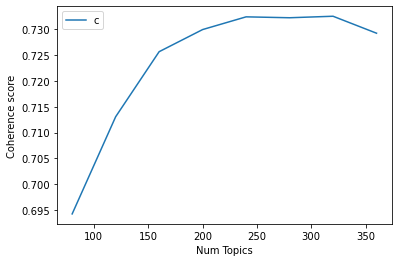

In [10]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=questions, start=80, limit=400, step=40)
import matplotlib.pyplot as plt
# Show graph
limit=400; start=80; step=40;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [11]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=10))

[(134, '0.189*"thing" + 0.135*"flying" + 0.095*"work" + 0.041*"youth" + 0.041*"today" + 0.041*"board" + 0.027*"specific" + 0.027*"issue" + 0.014*"disability" + 0.014*"goldaafamily"'), (59, '0.200*"give" + 0.060*"dreamliner" + 0.060*"land" + 0.040*"excited" + 0.020*"stone" + 0.020*"level" + 0.020*"counting" + 0.020*"belt" + 0.020*"allergy" + 0.020*"blood"'), (53, '0.356*"time" + 0.051*"flying" + 0.034*"issue" + 0.034*"christmas" + 0.017*"quicker" + 0.017*"blueberry" + 0.017*"hesitation" + 0.017*"sadface" + 0.017*"dumb" + 0.017*"pet"'), (115, '0.211*"wifi" + 0.158*"counter" + 0.070*"scheduled" + 0.053*"ahead" + 0.053*"thanksgiving" + 0.035*"minor" + 0.018*"awful" + 0.018*"false" + 0.018*"color" + 0.018*"email"'), (34, '0.230*"hour" + 0.122*"empty" + 0.081*"flight" + 0.068*"fit" + 0.041*"canceled" + 0.027*"missing" + 0.027*"mess" + 0.014*"science" + 0.014*"call" + 0.014*"scotland"'), (144, '0.128*"contact" + 0.064*"hotel" + 0.064*"customer" + 0.064*"front" + 0.043*"relax" + 0.043*"plane" 

In [12]:
def format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=questions):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=df.question.values.tolist())

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

/tmp/ipykernel_28508/2695061543.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/tmp/ipykernel_28508/2695061543.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0              76              0.0126   
1            1              62              0.0129   
2            2             119              0.0369   
3            3             170              0.0187   
4            4               6              0.0177   
5            5             115              0.0513   
6            6              65              0.0570   
7            7             182              0.0297   
8            8             177              0.0190   
9            9             162              0.0164   

                                            Keywords  \
0  flight, food, worst, pass, nice, dealing, vouc...   
1  gate, people, plane, checked, airplane, team, ...   
2  airline, american, flight, read, miami, long, ...   
3  boarding, pas, booking, person, albany, card, ...   
4  people, great, date, twitter, policy, notify, ...   
5  wifi, counter, scheduled, ahead, thanksgiving,...   
6  club, admiral, terminal, view, space, thankful...   
7  group, reservation, staff, disappointed, tight...   
8  minute, hold, guy, month, double, charlotte, c...   
9  wait, sitting, agent, point, person, care, mes...   

                                                Text  
0  @AmericanAir Erica on the lax team is amazing ...  
1  @AmericanAir Could you have someone on your la...  
2  Ben Tennyson and an American Airlines pilot. 🎃...  
3  @AmericanAir Right, but I earned those. I also...  
4  Thank you, @AmericanAir for playing #ThisIsUs ...  
5  @AmericanAir's wifi makes Amtrak's wifi look p...  
6  Wonderful club! @americanair (@ American Airli...  
7  @AmericanAir already did...changed browsers, d...  
8  @AmericanAir ........still....on....hold.....t...  
9  @AmericanAir well now i am told the ticket cos...

In [13]:
userinput=preprocess("@AmericanAir Erica on the lax team is amazing give her a raise ty")
dictionaryInput = corpora.Dictionary([userinput])
corpusInput = [dictionary.doc2bow(userinput)]

df_topic_test = format_topics_sentences(ldamodel=optimal_model, corpus=corpusInput, texts="@AmericanAir Erica on the lax team is amazing give her a raise ty")

# Format
df_dominant_topic_test = df_topic_test.reset_index()
df_dominant_topic_test.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic_test.head()


/tmp/ipykernel_28508/2695061543.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0              76              0.0126   

                                            Keywords  \
0  flight, food, worst, pass, nice, dealing, vouc...   

                                                Text  
0  @AmericanAir Erica on the lax team is amazing ...

In [14]:
complete_df= df.join(df_dominant_topic, lsuffix='_database', rsuffix='_input')
complete_df.head()

question  \
0  @AmericanAir Erica on the lax team is amazing ...   
1  @AmericanAir Could you have someone on your la...   
2  Ben Tennyson and an American Airlines pilot. 🎃...   
3  @AmericanAir Right, but I earned those. I also...   
4  Thank you, @AmericanAir for playing #ThisIsUs ...   

                                            responce  Document_No  \
0  @115904 We'll be sure to pass along your kind ...            0   
1  @115904 Our apologies for the delay in respond...            1   
2  @115905 Aww, that's definitely a future pilot ...            2   
3          @115906 We're sorry for your frustration.            3   
4  @115909 We're glad you got to kick back and en...            4   

   Dominant_Topic  Topic_Perc_Contrib  \
0              76              0.0126   
1              62              0.0129   
2             119              0.0369   
3             170              0.0187   
4               6              0.0177   

                                            Keywords  \
0  flight, food, worst, pass, nice, dealing, vouc...   
1  gate, people, plane, checked, airplane, team, ...   
2  airline, american, flight, read, miami, long, ...   
3  boarding, pas, booking, person, albany, card, ...   
4  people, great, date, twitter, policy, notify, ...   

                                                Text  
0  @AmericanAir Erica on the lax team is amazing ...  
1  @AmericanAir Could you have someone on your la...  
2  Ben Tennyson and an American Airlines pilot. 🎃...  
3  @AmericanAir Right, but I earned those. I also...  
4  Thank you, @AmericanAir for playing #ThisIsUs ...

In [15]:
oui = complete_df[complete_df['Dominant_Topic']==168.0]
oui.head()

question  \
624   @AmericanAir I’m onboard AA2241 bounded to Gua...   
853   @AmericanAir What is your policy on canceling ...   
1023  fuck @AmericanAir terrible company terrible st...   
1111  @AmericanAir @British_Airways Thanks for ride ...   
1167  @AmericanAir new computer selected bag policy ...   

                                               responce  Document_No  \
624   @137443 We count on our agents to always be pr...          624   
853   @145423 If you share your record locator and d...          853   
1023  @153491 If you need some help with your travel...         1023   
1111  @152574 Nice kicks! We love when you get upgra...         1111   
1167  @157797 We're sorry you had to check your bag ...         1167   

      Dominant_Topic  Topic_Perc_Contrib  \
624              168              0.0755   
853              168              0.0203   
1023             168              0.0227   
1111             168              0.0136   
1167             168              0.0711   

                                               Keywords  \
624   terrible, computer, city, attendant, policy, s...   
853   terrible, computer, city, attendant, policy, s...   
1023  terrible, computer, city, attendant, policy, s...   
1111  terrible, computer, city, attendant, policy, s...   
1167  terrible, computer, city, attendant, policy, s...   

                                                   Text  
624   @AmericanAir I’m onboard AA2241 bounded to Gua...  
853   @AmericanAir What is your policy on canceling ...  
1023  fuck @AmericanAir terrible company terrible st...  
1111  @AmericanAir @British_Airways Thanks for ride ...  
1167  @AmericanAir new computer selected bag policy ...

In [16]:
pd.set_option('display.max_colwidth', None)
oui.question.iloc[:1]

624    @AmericanAir I’m onboard AA2241 bounded to Guatemala City. Your chief flight attendant is extremely rude. Terrible demeanor. In addition she makes this “terrible” remark over the PA: “we have a full flight today, as for some reason everyone wants to go to Guatemala.” Not nice!
Name: question, dtype: object

In [40]:
oui.responce.iloc[:1]

624    @137443 We count on our agents to always be professional and courteous, Andre. We'll be sure to forward your comments to our flight services.
Name: responce, dtype: object

In [17]:
oui.iloc[(oui['Topic_Perc_Contrib']-0.0207).abs().argsort()[:1]]


question  \
853  @AmericanAir What is your policy on canceling flight due to medical illness &amp; emergency?   

                                                                                                   responce  \
853  @145423 If you share your record locator and details via DM, then we'd be happy to take a closer look.   

     Document_No  Dominant_Topic  Topic_Perc_Contrib  \
853          853             168              0.0203   

                                                                             Keywords  \
853  terrible, computer, city, attendant, policy, suck, rude, helped, ride, emergency   

                                                                                             Text  
853  @AmericanAir What is your policy on canceling flight due to medical illness &amp; emergency?

In [18]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

Topic_Num  Topic_Perc_Contrib  \
0          0              0.0559   
1          1              0.0330   
2          2              0.0351   
3          3              0.0690   
4          4              0.0470   

                                                                                   Keywords  \
0                   pilot, issue, agent, window, give, cancun, understand, ton, bag, fiance   
1                 flight, annoyed, poor, rock, mom, refunded, abusive, gotcha, cabin, spent   
2  delayed, preferred, closed, made, thinking, redeye, custom, morning, wing, neverflyagain   
3                        change, back, made, open, seat, support, snack, host, min, showing   
4              voucher, hope, high, talked, wrong, security, pathetic, wifi, contact, hotel   

                                                                                                                                                                                                                                                                                    Text  
0  @AmericanAir stuck on flight 609 in Charlotte over 55 minutes due to a computer card tech issue while pilot repeatedly advised it would only take a "few minutes" to fix. Why wasn't this issue reported by previous pilot that arrived minutes b4 we boarded in effort to save time?  
1                                                                                                                               Shared my flight with a #K9. Keep him and his handler in your thoughts and prayers as they head overseas. @AmericanAir you rock! https://t.co/XVQdg06HaP  
2                                                                                                                                       @AmericanAir Preferred over what?? Group 17? The cargo? Holding onto a wheel? Crawling home? Why call it preferred? I’d prefer not to be misled.  
3                                                                                                                             I’m getting Poke from Pokeland as soon as I get back to TO. I’m freaking hungry as heck and @AmericanAir didn’t give out any crappy snacks on my flight :(  
4                                                                                                                                           @AmericanAir  Your Vouchers are NOT good for Travel to the US from the UK? That RT was $500. $2600 ONE WAY from US to UK? Voucher=worthless!

<h2>Tag and train data with Doc2Vec</h2>

In [24]:
def preprocess_sentences(text):    
    emoticon_string = r"""
    (?:
      [<>]?
      [:;=8]                     # eyes
      [\-o\*\']?                 # optional nose
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth      
      |
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      [\-o\*\']?                 # optional nose
      [:;=8]                     # eyes
      [<>]?
    )"""
    
    # Remove stopwords 
    answers  = []
    for i in df.responce:
        i = give_emoji_free_text(i).lower()
        answers.append(re.sub(r'\s+', ' ',
                            re.sub(r'\[[0-9]*\]', ' ',
                            re.sub(r'(@([A-Za-z0-9`~!@#$%^&*()_|+\-=?;:\'",.<>\{\}\[\]\\\/]{2,32}))', '', # remove tags
                            re.sub(r'\d+', ' ', # remove numbers
                            re.sub(r'\#+', ' ', # remove hashtags
                            re.sub(r'http\S+', ' ', # remove urls
                            re.sub(emoticon_string,'', # remove emojis
                            re.sub(r'[\.\?\!\,\:\;\"]', '', i) # remove punctuation
                                  ))))))))
    # Lemmatization and tokenization
    sentences = []
    le = WordNetLemmatizer()
    for i in answers:
        word_tokens = word_tokenize(i)
        lemmas = [ le.lemmatize(w) for w in word_tokens if w not in stop_words and len(w) > 3 ]
        cleaned_text=" ".join(lemmas)
        sentences.append(cleaned_text)
    
    return sentences

In [25]:
#processed_corpus = preprocess_documents(responses)
answer_sentences = preprocess_sentences(df.responce)
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(answer_sentences)]

/tmp/ipykernel_28508/4218898814.py:2: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  return emoji.get_emoji_regexp().sub(r'', text)


In [26]:
tagged_data

[TaggedDocument(words='sure pas along kind word aateam', tags=[0]),
 TaggedDocument(words='apology delay responding made know still need assistance', tags=[1]),
 TaggedDocument(words='definitely future pilot making happyhalloween', tags=[2]),
 TaggedDocument(words='sorry frustration', tags=[3]),
 TaggedDocument(words='glad kick back enjoy show flying thanks kind word', tags=[4]),
 TaggedDocument(words='never want experience anything le perfect sorry wi-fi slower expected', tags=[5]),
 TaggedDocument(words='thanks shout-out stopping marc pas admiral club manager', tags=[6]),
 TaggedDocument(words='happy walk help booking process', tags=[7]),
 TaggedDocument(words='sorry long wait next available agent soon possible', tags=[8]),
 TaggedDocument(words='fare sell real time sorry able snag lower fare', tags=[9]),
 TaggedDocument(words='glad reservation team able help', tags=[10]),
 TaggedDocument(words='sorry frustration damage must assessed person within hour arrival airport personnel', tag

In [30]:
model = Doc2Vec(tagged_data, 
                vector_size=200, 
                epochs=100, 
                hs=1, # use of hierachical softmax
                min_count=1, 
                window=2, # Max distance
                dm =0) # PV-Bag of words used
  
#model.build_vocab(tagged_data) #uncomment the first time
train_corpus = [taggeddoc for taggeddoc_list in tagged_data for taggeddoc in taggeddoc_list]

for epoch in range(model.epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=2,
                epochs=100)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")


iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration

In [36]:
def response_sentences(most_similar):
    answer = []
    for label,index in [('MOST', 0)]:#, ('SECOND-MOST', 1), ('MEDIAN', len(most_similar)//2), ('LEAST', len(most_similar) - 1)]:
        answer.append(answer_sentences[int(most_similar[index][0])])
        #print(u'%s %s: %s\n' % (label, most_similar[index][1], cleaned_sentences[int(most_similar[index][0])]))
    return answer

In [37]:
def response(user_query):
    # Using TFID Add the query to the answers list and vectorize it, then measure the cosine similarity between query and answers
    """cleaned_sentences.append(user_query)
    vectorizer = TfidfVectorizer(stop_words=stop_words,max_features=1000)
    sentences_vectors = vectorizer.fit_transform(cleaned_sentences)
    
    similar_vector_values = cosine_similarity(sentences_vectors[-1], sentences_vectors)
    similar_sentence_number = similar_vector_values.argsort()[0][-2]
    
    matched_vector = similar_vector_values.flatten()
    matched_vector.sort()
    matched_vector = matched_vector[-2]

    if matched_vector == 0: # no vector matching
        return "I didn't understand, can you reformulate please ?"
    else: 
        return cleaned_sentences[similar_sentence_number]"""
    
    # Using doc2vec
    model= Doc2Vec.load("d2v.model")
    
    # vector of a document which is not in training data
    cleaned = word_tokenize(user_query.lower())
    v1 = model.infer_vector(cleaned)
    #print("V1_infer", v1)

    # most similar sentences using tags
    similar_doc = model.docvecs.most_similar([v1])
    return response_sentences(similar_doc)

## Starting Intents

In [38]:
# Greetings
greetings = ('hey', 'hello', 'whats up', 'good morning', 'good evening', 'morning', 'evening', 'hello there', 'hey there')
greeting_responses = ["hey", "hey hows you?", "*nods*", "hello, how you doing", "hello", "Welcome, I am good and you"]
# Goodbye
goodbye = ('bye', 'good bye', 'take care')
goodbye_responses = ['See you next time !', 'Bye see you next time ! Hope I was helpful :p']
# Apology
apology = ['sorry', 'I apologize', 'disapointed']
# Thanks
thanks =('thank you', 'thanks', 'grateful', 'pleased')
thanks_responses = ['Always a pleasure to help you !', 'You\'re welcome !', 'No problem ! :)']
def greeting_response(query):
    for token in query.split():
        if token.lower() in greetings:
            return random.choice(greeting_responses)
        if token.lower() in thanks:
            return random.choice(thanks_responses)
        if token.lower() in goodbye:
            return random.choice(goodbye_responses)
            break

In [39]:
print("Hello, I am the bot assistant of American Air, here to answer to your questions. Please ask me anything :))")

while(True):
    query = input().lower()
    if query not in goodbye:
        if query in greetings or query in thanks or query in goodbye:
            print(greeting_response(query))
        else:
            print("Twitter Chatbot: ", end="")
            print(response(query))
            #cleaned_sentences.remove(query)
    else:
        print()
        break

Hello, I am the bot assistant of American Air, here to answer to your questions. Please ask me anything :))
I’m onboard AA2241 bounded to Guatemala City. Your chief flight attendant is extremely rude. Terrible demeanor. In addition she makes this “terrible” remark over the PA: “we have a full flight today, as for some reason everyone wants to go to Guatemala.” Not nice!
Twitter Chatbot: ['team look certain availability using mile want direct flight award open using mile']
bye

